In [1]:
import os
import re
import statistics
import pickle
import itertools
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import UpSet
from tqdm import tqdm

import score_utils

# Import relevant dataframes

## ProbCBR results

In [2]:
# Import probCBR res
def json_to_df(json_dir: str) -> pd.DataFrame:
    """
    Takes a string to a json object and turns it into a dataframe
    """
    # import the json object
    with open(json_dir, "r") as f:
        json_obj = json.load(f)

    # creates a dict with json keys as keys and values of emptylist based on the first json entry
    json_key_dict = {i: [] for i in list(json_obj[0].keys())}
    for i in json_obj:
        for j in json_key_dict.keys():
            # add j key in json item i to the list
            to_add = json_key_dict[j]
            to_add.append(i[j])
            json_key_dict.update({j: to_add})

    return pd.DataFrame(json_key_dict)

In [3]:
pcbr_df = json_to_df("/home/msinha/Open-BIo-Link/data.json")

In [4]:
pcbr_df.head(2)

e1               r  \
0  CHEBI:135735      indication   
1    DOID:10763  indication_inv   

                                             answers  \
0                                       [DOID:10763]   
1  [CHEBI:135735, CHEBI:135738, CHEBI:141521, CHE...   

                                   predicted_answers  
0  [DOID:6432, DOID:6000, DOID:10763, DOID:10591,...  
1  [CHEBI:31548, CHEBI:46632, CHEBI:5784, CHEBI:5...

In [5]:
def process_dataframe(
    df: pd.DataFrame,
    data_dir: str,
    model_dir: str,
    mode: str = "tail-batch",
    rel=[
        "indication",
        "indication_CiD",
    ],
):
    """
    Gets True tail triples
    """

    # get true head/tail triples from graph
    raw = score_utils.ProcessOutput(
        data_dir=data_dir,
        scores_outfile=os.path.join(model_dir, "test_scores.tsv"),
        mode=mode,
    )
    graph = raw.get_true_targets()
    graph = graph.query("r in @rel")

    if mode == "tail-batch":
        # get true tail triples from graph

        merged = pd.merge(
            left=df[["e1", "r", "answers", "predicted_answers"]].rename(
                columns={"e1": "h"}
            ),
            right=graph,
            how="left",
            on=["h", "r"],
        )
        merged = merged.rename(columns={"t": "true_t"})

        # ensure answers is in 'true_t'. First remove all predicted answers with no predictions
        merged = merged[merged["predicted_answers"].apply(lambda x: len(x) > 0)]
        # add answers to true t
        merged["true_t"] = [
            list(set(val) | set(merged.answers.iloc[ind]))
            if type(val) != float
            else list(set(merged.answers.iloc[ind]))
            for ind, val in enumerate(merged.true_t)
        ]

    elif mode == "head-batch":
        # get True head triples from graph
        merged = pd.merge(
            left=df[["e1", "r", "answers", "predicted_answers"]].rename(
                columns={"e1": "t"}
            ),
            right=graph,
            how="left",
            on=["r", "t"],
        )
        merged = merged.rename(columns={"t": "true_h", "h": "t"})

        # ensure answers is in 'true_t'. First remove all predicted answers with no predictions
        merged = merged[merged["predicted_answers"].apply(lambda x: len(x) > 0)]
        # add answers to true t
        merged["true_h"] = [
            list(set(val) | set(merged.answers.iloc[ind]))
            if type(val) != float
            else list(set(merged.answers.iloc[ind]))
            for ind, val in enumerate(merged.true_h)
        ]

    else:
        raise ValueError(f'{batch} is not in {"head-batch","tail-batch"}')
    return merged


# def filter_predictions(df: pd.DataFrame, top: int = 50) -> pd.DataFrame:
#     """
#     Get filtered predictions that don't exist as triples in Train/Test/Valid

#     Inputs
#     -----------
#     - df        * dataframe to translate embeddings
#     - top       * get the top 'n' results for each prediction.
#                 * `top = -1` if you want all results
#     """
#     # remove answer from predicted_answers
#     df["filt_preds"] = df.apply(
#         lambda i: score_utils.ProcessOutput.remove_list_from_list(
#             i["predicted_answers"], i["answers"]
#         ),
#         axis=1,
#     )
#     df = df.rename(columns={"t": "true_t"}).drop(columns="predicted_answers")

#     # get the top number of predictions
#     df["filt_preds"] = df["filt_preds"].apply(lambda x: x[0:top])

#     return df

In [6]:
## get indications only
pcbr_df = process_dataframe(
    df=pcbr_df,
    data_dir="../data/MIND_CtD/",
    model_dir="../models/TransE_MIND_CtD_megha",
)

In [7]:
# note that true_t are all unique answers
pcbr_df = pcbr_df.query('r=="indication"')

In [8]:
def flatten_list(a_ls: list) -> list:
    """
    given a list of list, flatten to a 1D list
    """
    return_ls = list()
    for i in a_ls:
        min_ls = list()
        for j in i:
            if type(j) == list:
                for k in j:
                    min_ls.append(k)
            else:
                min_ls.append(j)
        min_ls = list(set(min_ls))
        return_ls.append(min_ls)

    return return_ls

In [9]:
# flatten true_t
pcbr_df.true_t = flatten_list(pcbr_df.true_t)

In [10]:
# ensure answers are in true_t


def add_list_to_list(ls1: list, ls2: list) -> list:
    """
    Given two lists of lists, add list from ls1 to ls2 at the same index
    ls1: list to add to another list
    ls2: list to extend
    """

    for i, val in enumerate(ls1):
        ls2_item = ls2[i]
        ls2_item.extend(val)
        ls2[i] = list(set(ls2_item))

    return ls2


# true_ls_ls = list(pcbr_df.true_t)
# for i, val in enumerate(list(pcbr_df.answers)):
#     true_ls = true_ls_ls[i]
#     true_ls.extend(val)
#     true_ls_ls[i] = list(set(true_ls))

pcbr_df.true_t = add_list_to_list(list(pcbr_df.answers), list(pcbr_df.true_t))
pcbr_df["algo"] = "pCBR"

In [11]:
pcbr_df.head(2)

h           r       answers  \
0  CHEBI:135735  indication  [DOID:10763]   
2  CHEBI:135738  indication  [DOID:10763]   

                                   predicted_answers  \
0  [DOID:6432, DOID:6000, DOID:10763, DOID:10591,...   
2  [DOID:10763, DOID:446, DOID:10591, DOID:10824,...   

                                              true_t  algo  
0  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  pCBR  
2  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  pCBR

### Some checks

In [12]:
pcbr_df.predicted_answers.apply(lambda x: len(x)).describe()

count    359.000000
mean      99.813370
std        2.854231
min       48.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: predicted_answers, dtype: float64

In [13]:
# Check to see if length of true_t == length of the set of true_t
pcbr_df["true_t2"] = pcbr_df.true_t.apply(lambda x: list(set(x)))
pcbr_df["len"] = pcbr_df.true_t.apply(lambda x: len(x))
pcbr_df["len2"] = pcbr_df.true_t2.apply(lambda x: len(x))

In [14]:
set(pcbr_df.len == pcbr_df.len2)

{True}

In [15]:
tf_counter = defaultdict(lambda: 0)

In [16]:
# Check if all true answers according to CBR is nested in true answers
# two of them are not.

# default dict with default val at 0
tf_counter = defaultdict(lambda: 0)

for binary in [
    len(
        ls.intersection(list(pcbr_df.answers.apply(lambda x: set(x)))[i])
    )  # set of tails from test
    == len(list(pcbr_df.answers)[i])  # a True tail
    for i, ls in enumerate(
        list(pcbr_df.true_t.apply(lambda x: set(x)))
    )  # iterates over true_t list of lists
]:
    if binary == True:
        tf_counter["T"] += 1
    else:
        tf_counter["F"] += 1

tf_counter

defaultdict(<function __main__.<lambda>()>, {'T': 357, 'F': 2})

## CBR results

In [17]:
cbr_df = json_to_df("/home/msinha/CBR-AKBC/results/data_CBRonMIND_CtD.json")

In [18]:
cbr_df = process_dataframe(
    df=cbr_df, data_dir="../data/MIND_CtD", model_dir="../models/TransE_MIND_CtD_megha/"
)

In [19]:
# ensure answers are in true_t
cbr_df.true_t = flatten_list(list(cbr_df.true_t))
cbr_df.true_t = add_list_to_list(list(cbr_df.answers), list(cbr_df.true_t))
cbr_df["algo"] = "CBR"

In [20]:
cbr_df.head(2)

h           r       answers  \
0  CHEBI:135735  indication  [DOID:10763]   
1  CHEBI:135738  indication  [DOID:10763]   

                                   predicted_answers  \
0  [DOID:3393, DOID:6000, DOID:10763, DOID:3683, ...   
1  [HP:0000006, HP:0000007, HP:0001425, HP:000142...   

                                              true_t algo  
0  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  CBR  
1  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  CBR

## Rephetio Results

In [21]:
raw = score_utils.ProcessOutput(
    data_dir="../data/MIND_CtD/",
    scores_outfile=os.path.join("../models/TransE_MIND_CtD_megha/", "test_scores.tsv"),
    mode="tail-batch",
)
known_triples = raw.get_true_targets()
known_triples = known_triples.query("r == 'indication' or r == 'indication_CiD'")

# get unique chemicalsubstances and group the items togeher
rephetio = (
    pd.read_csv(
        "../../MechRepoNet/1_code/KG_reasoning_comparison/Rephetio_MIND_CtD_test/results.csv"
    )
    .sort_values(by="proba", ascending=False)
    .groupby("chemicalsubstance_id")
    .agg(lambda x: list(x))
    .reset_index()
    .rename(columns={"chemicalsubstance_id": "h", "disease_id": "predicted_answers"})[
        ["h", "predicted_answers", "proba"]
    ]
)

rephetio["algo"] = "Rephetio"

# merge known answers with rephetio to get a list of known answers per chemical compound. Just formatting
rephetio = pd.merge(left=rephetio, right=known_triples, on="h", how="left").rename(
    columns={"t": "answers"}
)[["h", "predicted_answers", "answers", "proba", "algo"]]

In [22]:
rephetio.head(2)

h                                  predicted_answers  \
0  CHEBI:135735  [DOID:10763, DOID:5844, DOID:10825, DOID:2559,...   
1  CHEBI:135738  [DOID:10763, DOID:0060224, DOID:10825, DOID:58...   

                                             answers  \
0  [DOID:10591, DOID:10824, DOID:10825, DOID:1113...   
1  [DOID:10591, DOID:10824, DOID:10825, DOID:1113...   

                                               proba      algo  
0  [0.6733899229161452, 0.1993276939787308, 0.091...  Rephetio  
1  [0.9325203250946036, 0.780770655712133, 0.5917...  Rephetio

In [23]:
# limit predicted answers to top 100
rephetio.predicted_answers.apply(lambda x: len(x)).describe()

count    374.0
mean     944.0
std        0.0
min      944.0
25%      944.0
50%      944.0
75%      944.0
max      944.0
Name: predicted_answers, dtype: float64

In [24]:
rephetio["predicted_answers"] = rephetio["predicted_answers"].apply(lambda x: x[0:100])
rephetio.predicted_answers.apply(lambda x: len(x)).describe()

count    374.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: predicted_answers, dtype: float64

## KGE results

In [25]:
kge_ls = list()
for i in ["TransE", "DistMult", "ComplEx", "RotatE"]:
    print(i)
    raw = score_utils.ProcessOutput(
        data_dir="../data/MIND_CtD",
        scores_outfile=f"../models/{i}_MIND_CtD_megha/test_scores.tsv",
        mode="tail-batch",
    )
    raw.format_raw_scores_to_df()
    raw.translate_embeddings(direction="from")

    df = raw.filter_predictions(top=100).query('batch=="tail-batch"')
    # limit to top 100
    df["preds"] = df["preds"].apply(lambda x: x[0:100])
    df["algo"] = i
    kge_ls.append(df)
    print(f"Shape: {df.shape}")

TransE
Shape: (537, 7)
DistMult
Shape: (537, 7)
ComplEx
Shape: (537, 7)
RotatE
Shape: (537, 7)


In [26]:
kge_df = pd.concat(kge_ls)

In [27]:
kge_df.head(2)

h           r  \
537  CHEBI:135735  indication   
538  CHEBI:135738  indication   

                                                 preds       batch  \
537  [CHEBI:135735, DOID:9654, UMLS:C0221155, WD:Q2...  tail-batch   
538  [CHEBI:135738, DOID:10763, DOID:9654, WD:Q2530...  tail-batch   

                                                true_t  \
537  [DOID:10591, DOID:10824, DOID:10825, DOID:1113...   
538  [DOID:10591, DOID:10824, DOID:10825, DOID:1113...   

                                            filt_preds    algo  
537  [DOID:9654, UMLS:C0221155, WD:Q25303605, MONDO...  TransE  
538  [DOID:9654, WD:Q25303605, UMLS:C0221155, CHEBI...  TransE

In [28]:
# unique compounds
len(set(kge_df.h))

387

In [29]:
kge_df.shape

(2148, 7)

In [31]:
kge_df = kge_df.drop_duplicates(subset=["h", "r", "algo"])
kge_df.shape

(1548, 7)

In [32]:
kge_df.head(2)

h           r  \
537  CHEBI:135735  indication   
538  CHEBI:135738  indication   

                                                 preds       batch  \
537  [CHEBI:135735, DOID:9654, UMLS:C0221155, WD:Q2...  tail-batch   
538  [CHEBI:135738, DOID:10763, DOID:9654, WD:Q2530...  tail-batch   

                                                true_t  \
537  [DOID:10591, DOID:10824, DOID:10825, DOID:1113...   
538  [DOID:10591, DOID:10824, DOID:10825, DOID:1113...   

                                            filt_preds    algo  
537  [DOID:9654, UMLS:C0221155, WD:Q25303605, MONDO...  TransE  
538  [DOID:9654, WD:Q25303605, UMLS:C0221155, CHEBI...  TransE

In [ ]:
# what are the reciprocal ranks of answers for each algo by itself
# what is the reciprocal rank of  answers for each pair of algos
# fraction of results that overlap (including answers) in the top 100

## Unify all headers in all datasets

In [33]:
# cbr and rephetio don't yield results for some of the compound disease predictions
(
    len(
        set(pcbr_df["h"])
        .intersection(set(cbr_df["h"]))
        .intersection(set(rephetio["h"]))
        .intersection(set(kge_df.query('algo=="TransE"')["h"]))
    )
)

322

In [34]:
intersection_ls = list(
    set(pcbr_df["h"])
    .intersection(set(cbr_df["h"]))
    .intersection(set(rephetio["h"]))
    .intersection(set(kge_df.query('algo=="TransE"')["h"]))
)

In [35]:
cbr_df = cbr_df.explode(column="answers").query("h in @intersection_ls")

In [36]:
cbr_df.shape

(460, 6)

In [37]:
pcbr_df = pcbr_df.explode(column="answers").query("h in @intersection_ls")

In [38]:
pcbr_df.shape

(460, 9)

In [39]:
rephetio_df = rephetio[["h", "predicted_answers", "algo"]]

In [40]:
# reorganize the dataframe and merge in true_answer
rephetio_df = pd.merge(
    left=rephetio_df,
    right=cbr_df[["h", "r", "answers", "true_t"]],
    on="h",
    how="right",
)[["h", "r", "answers", "predicted_answers", "true_t", "algo"]]

In [41]:
rephetio_df.head(1)

h           r     answers  \
0  CHEBI:135735  indication  DOID:10763   

                                   predicted_answers  \
0  [DOID:10763, DOID:5844, DOID:10825, DOID:2559,...   

                                              true_t      algo  
0  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  Rephetio

In [42]:
rephetio_df.shape

(460, 6)

In [43]:
# groupby cbr again..
cbr_df_groupby = cbr_df[["h", "answers"]].groupby("h").agg(list)

In [44]:
cbr_df_groupby.head(1)

answers
h                         
CHEBI:135735  [DOID:10763]

In [45]:
# reogranize kge df
kge_df = (
    pd.merge(left=kge_df, right=cbr_df_groupby, on="h", how="left")
    .query("h in @intersection_ls")[["h", "r", "answers", "preds", "true_t", "algo"]]
    .explode("answers")
)

### Check if True Tails are the same across all entries. 
* If not, fix it.

Code to check if all the true's are the same. They aren't

```python
check_trues = (
    kge_df.query('algo=="TransE"')[["h", "true_t"]]
    .drop_duplicates("h")
    .merge(
        kge_df.query('algo=="DistMult"')[["h", "true_t"]].drop_duplicates("h"),
        on="h",
        how="left",
    )
    .merge(
        kge_df.query('algo=="ComplEx"')[["h", "true_t"]].drop_duplicates("h"),
        on="h",
        how="left",
    )
    .merge(
        kge_df.query('algo=="RotatE"')[["h", "true_t"]].drop_duplicates("h"),
        on="h",
        how="left",
    )
    .merge(
        pcbr_df[["h", "true_t"]].drop_duplicates("h"),
        on="h",
        how="left",
    )
    .merge(cbr_df[["h", "true_t"]].drop_duplicates("h"), on="h", how="left")
)

check_trues.columns = ["h", "t1", "t2", "t3", "t4", "t5", "t6"]

t2 = list(check_trues["t2"])
t3 = list(check_trues["t3"])
t4 = list(check_trues["t4"])
t5 = list(check_trues["t5"])
t6 = list(check_trues["t6"])

tf_ls = [
    list(set(ls))
    == list(set(t2[i]))
    == list(set(t3[i]))
    == list(set(t4[i]))
    == list(set(t5[i]))
    == list(set(t6[i]))
    for i, ls in enumerate(check_trues["t1"])
]

print(f"Total Trues: {sum(tf_ls)}/{len(tf_ls)}")
```

Returns -> Total Trues: 279/322

Which indices aren't matching?
``` python
[i for i, tf in enumerate(tf_ls) if tf == False]
```
\[12, 13, 19, 21, 34, 37, 38, 43, 44, 49, 50, 56, 63, 72,
 76, 84, 92, 104, 109, 114, 131, 133, 136, 137, 142, 147,
 163, 165, 186, 188, 198, 201, 206, 213, 225, 227, 244,
 256, 259, 272, 281, 299, 301]

In [46]:
# combine all df together
combined_df = pd.concat(
    [
        cbr_df,
        pcbr_df,
        rephetio_df,
        kge_df.rename(columns={"preds": "predicted_answers"}),
    ]
)
combined_df.shape

(3220, 9)

In [47]:
# Get a consolidated list of Trues
get_h2targets = (
    combined_df[["h", "true_t"]]
    .explode("true_t")
    .groupby("h")
    .agg(lambda x: list(set(x)))
    .reset_index()
)

In [48]:
# create a dict to relabel true_ts
new_true_dict = dict(zip(get_h2targets["h"], get_h2targets["true_t"]))

In [49]:
combined_df["true_t2"] = [
    new_true_dict[val] for i, val in enumerate(list(combined_df["h"]))
]
combined_df.shape

(3220, 9)

In [50]:
combined_df["t_equal_t2"] = [
    set(list(combined_df["true_t"])[i]).issubset(set(val))
    for i, val in enumerate(list(combined_df["true_t2"]))
]

In [51]:
combined_df.query("t_equal_t2==False")

Empty DataFrame
Columns: [h, r, answers, predicted_answers, true_t, algo, true_t2, len, len2, t_equal_t2]
Index: []

In [52]:
# reset the indices after concatinations
combined_df = combined_df.reset_index()[
    ["h", "r", "answers", "predicted_answers", "true_t", "algo"]
]

In [54]:
combined_df.head(2)

h           r     answers  \
0  CHEBI:135735  indication  DOID:10763   
1  CHEBI:135738  indication  DOID:10763   

                                   predicted_answers  \
0  [DOID:3393, DOID:6000, DOID:10763, DOID:3683, ...   
1  [HP:0000006, HP:0000007, HP:0001425, HP:000142...   

                                              true_t algo  
0  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  CBR  
1  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  CBR

In [55]:
combined_df.shape

(3220, 6)

## Play with Upset

In [56]:
from upsetplot import from_contents

In [61]:
contents = {
    "CBR": list(combined_df.query('algo=="CBR"').predicted_answers.iloc[0]),
    "pCBR": list(combined_df.query('algo=="pCBR"').predicted_answers.iloc[0]),
    "Rephetio": list(combined_df.query('algo=="Rephetio"').predicted_answers.iloc[0]),
    "TransE": list(combined_df.query('algo=="TransE"').predicted_answers.iloc[0]),
    "DistMult": list(combined_df.query('algo=="DistMult"').predicted_answers.iloc[0]),
    "ComplEx": list(combined_df.query('algo=="ComplEx"').predicted_answers.iloc[0]),
    "RotatE": list(combined_df.query('algo=="RotatE"').predicted_answers.iloc[0]),
}

In [62]:
combined_df.query('algo=="RotatE"').predicted_answers

2760    [WD:Q25303605, UMLS:C0221155, DOID:10763, DOID...
2761    [DOID:10763, DOID:60164, DOID:11130, DOID:6432...
2762    [DOID:11817, DOID:5432, DOID:11820, DOID:5429,...
2763    [DOID:11476, DOID:10763, DOID:0060343, MESH:D0...
2764    [DOID:12858, DOID:10935, DOID:10825, HP:000218...
                              ...                        
3215    [DOID:11150, GO:0016020, GO:0016021, NCBITaxon...
3216    [DOID:11150, GO:0016020, GO:0016021, NCBITaxon...
3217    [WD:Q53910821, WD:Q4677939, MESH:D015472, WD:Q...
3218    [GO:0016853, GO:0046872, NCBITaxon:5833, GO:00...
3219    [DOID:9352, DOID:10182, DOID:11712, DOID:1837,...
Name: predicted_answers, Length: 460, dtype: object

In [63]:
from_contents(contents)

id
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE              
True  True  False    True   True     True    True       DOID:3393
                                             True       DOID:6000
            True     True   True     True    True      DOID:10763
      False False    False  False    False   False      DOID:3683
      True  False    False  False    True    True      DOID:60164
...                                                           ...
False False False    False  False    False   True       DOID:2722
                                             True    MESH:D011297
                                             True      DOID:11396
                                             True      DOID:12387
                                             True    DOID:0111154

[441 rows x 1 columns]

In [68]:
j = UpSet(data=from_contents(contents))

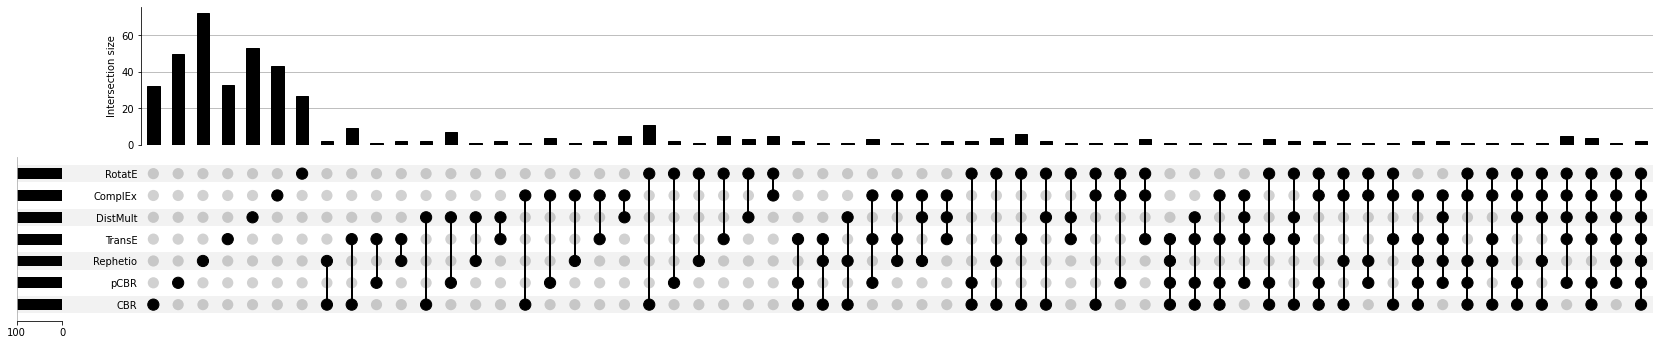

In [71]:
j

### how do we combine multiple series in a df?
* merge on row index?

In [72]:
contents2 = {
    "CBR": list(combined_df.query('algo=="CBR"').predicted_answers.iloc[1]),
    "pCBR": list(combined_df.query('algo=="pCBR"').predicted_answers.iloc[1]),
    "Rephetio": list(combined_df.query('algo=="Rephetio"').predicted_answers.iloc[1]),
    "TransE": list(combined_df.query('algo=="TransE"').predicted_answers.iloc[1]),
    "DistMult": list(combined_df.query('algo=="DistMult"').predicted_answers.iloc[1]),
    "ComplEx": list(combined_df.query('algo=="ComplEx"').predicted_answers.iloc[1]),
    "RotatE": list(combined_df.query('algo=="RotatE"').predicted_answers.iloc[1]),
}

In [124]:
pd.merge(
    left=from_contents(contents),
    right=from_contents(contents2),
    on=["CBR", "pCBR", "Rephetio", "TransE", "DistMult", "ComplEx", "RotatE"],
    how="outer",
).head(2)

id_x       id_y
CBR  pCBR Rephetio TransE DistMult ComplEx RotatE                      
True True False    True   True     True    True    DOID:3393  DOID:6000
                                           True    DOID:3393  DOID:6432

In [125]:
k = UpSet(
    data=pd.merge(
        left=from_contents(contents),
        right=from_contents(contents2),
        on=["CBR", "pCBR", "Rephetio", "TransE", "DistMult", "ComplEx", "RotatE"],
        how="outer",
    ),
    # intersection_plot_elements=0,
)
# k.add_catplot(kind='swarm', data = )

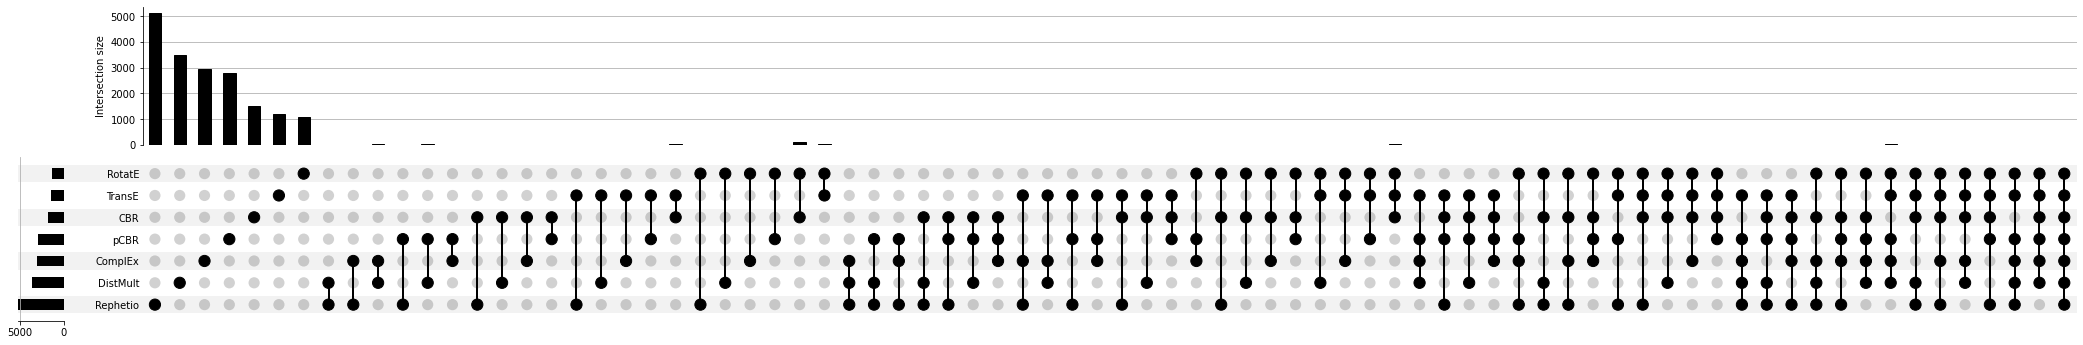

In [126]:
k

### What if we stack them..

In [80]:
dfset1 = from_contents(contents)
dfset1["set_val"] = 1
dfset2 = from_contents(contents2)
dfset2["set_val"] = 2

In [81]:
pd.concat([dfset1, dfset2])

id  set_val
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE                       
True  True  False    True   True     True    True       DOID:3393        1
                                             True       DOID:6000        1
            True     True   True     True    True      DOID:10763        1
      False False    False  False    False   False      DOID:3683        1
      True  False    False  False    True    True      DOID:60164        1
...                                                           ...      ...
False False False    False  False    False   True       DOID:3165        2
                                             True    DOID:0050861        2
                                             True    DOID:0060903        2
                                             True      DOID:12858        2
                                             True      DOID:13938        2

[939 rows x 2 columns]

/home/rogertu/python_venvs/RotatE/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 92.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rogertu/python_venvs/RotatE/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 94.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rogertu/python_venvs/RotatE/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 95.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rogertu/python_venvs/RotatE/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 91.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rogertu/python_ven

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>,
 'extra1': <AxesSubplot: xlabel='_bin', ylabel='set_val'>}

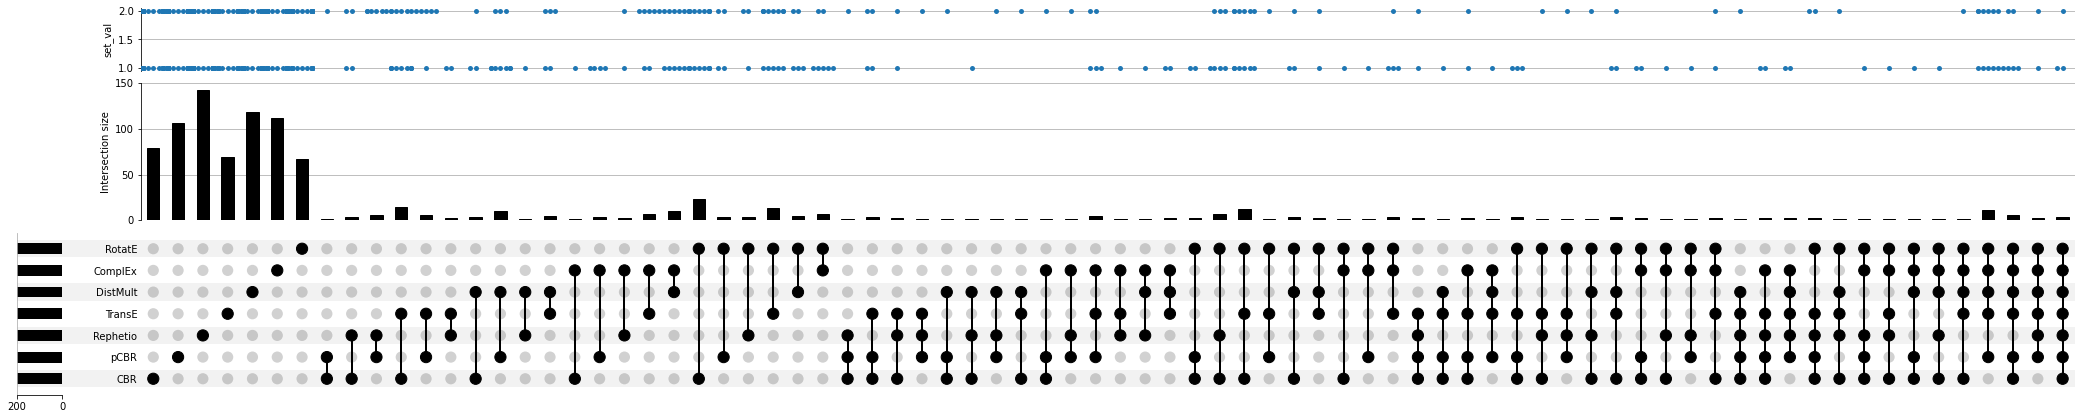

In [127]:
fig = plt.figure(figsize=(24, 6))
l = UpSet(
    data=pd.concat([dfset1, dfset2]),
    # intersection_plot_elements=0,
)
l.add_catplot(
    value="set_val",
    kind="swarm",
)

l.plot(fig=fig)

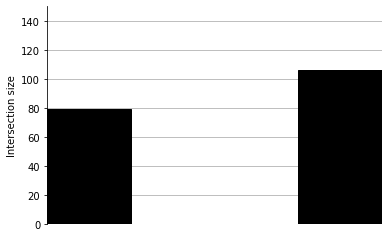

In [90]:
fig, ax = plt.subplots()
l.plot_intersections(ax)

plt.show()

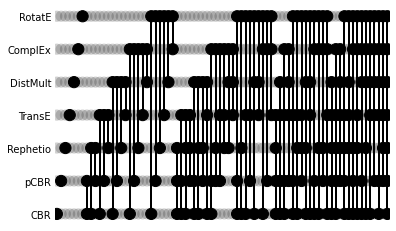

In [91]:
fig, ax = plt.subplots()
l.plot_matrix(ax)

plt.show()

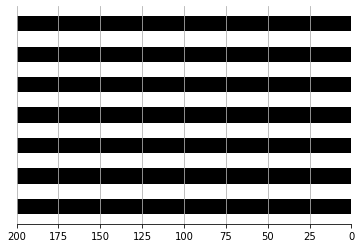

In [92]:
fig, ax = plt.subplots()
l.plot_totals(ax)
plt.show()

### combine multiple df results
* plot_totals max should be 100, not the sum of all the data because each set size is 100
* plot_matrix sizing needs to be larger
* figure out how to plot swarm and boxplot on the other axes

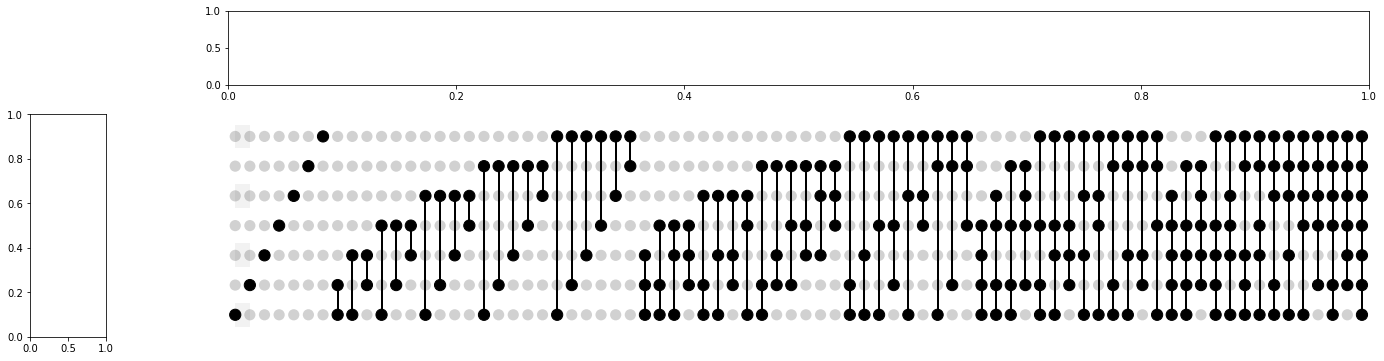

In [129]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    ncols=2, nrows=2, figsize=(24, 6), height_ratios=[1, 3], width_ratios=[1, 15]
)
ax0.axis("off")  # hides ax0, top left.

l.plot_shading(ax3)
l.plot_matrix(ax3)

plt.show()

In [133]:
import upsetplot

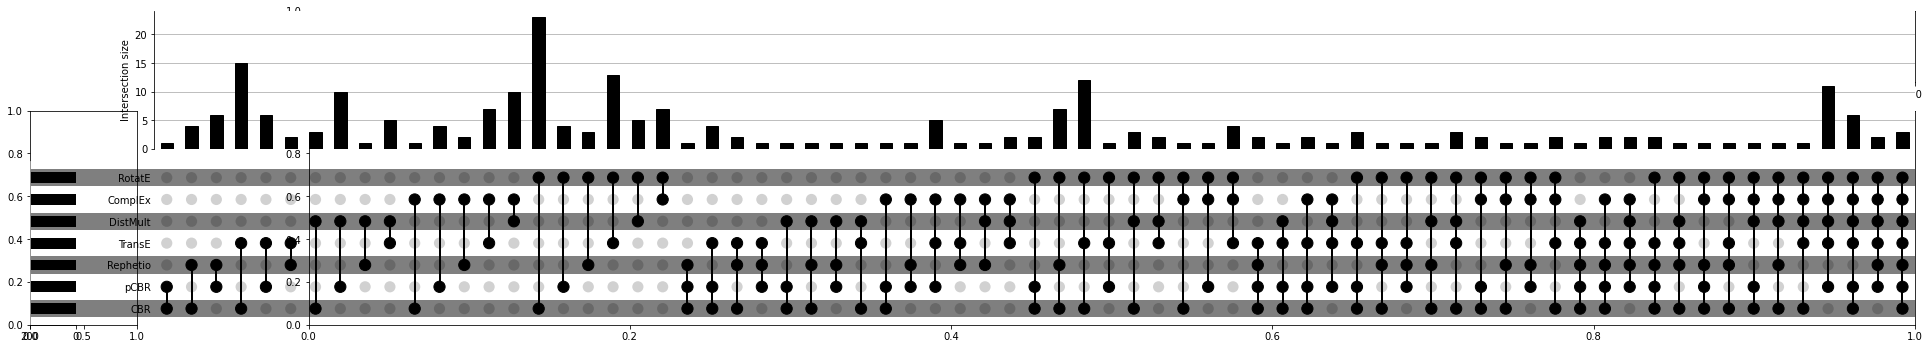

In [245]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    ncols=2, nrows=2, figsize=(24, 6), height_ratios=[1, 3], width_ratios=[1, 15]
)
ax0.axis("off")  # hides ax0, top left.

l = UpSet(
    data=pd.concat([dfset1, dfset2]),
    # intersection_plot_elements=0, # hides intersections
    min_degree=2,  # sets the number of combos,
    shading_color=0.50,
)
l.plot(fig=fig)

plt.show()

In [246]:
l.make_grid()

{'matrix': GridSpec(13, 76)[6:13, 5:76],
 'shading': GridSpec(13, 76)[6:13, 0:76],
 'totals': GridSpec(13, 76)[6:13, 0:2],
 'gs': GridSpec(13, 76),
 'intersections': GridSpec(13, 76)[0:6, 5:76]}

<Figure size 2432x416 with 0 Axes>

In [247]:
l._subset_plots

[{'type': 'default', 'id': 'intersections', 'elements': 6}]

/tmp/ipykernel_469220/3842578642.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1_shading.set_yticklabels(['1','2','3','4','5','6','7'])


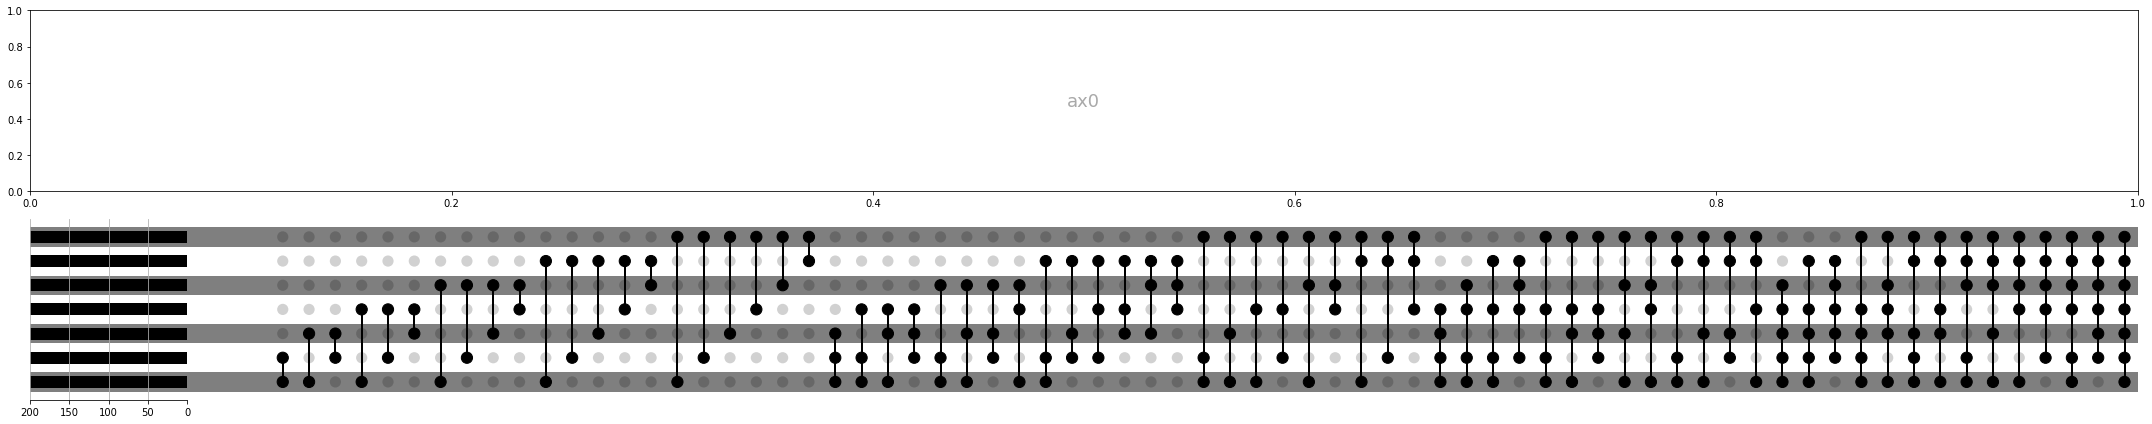

In [263]:
def annotate_axes(ax, text, fontsize=18):
    ax.text(
        0.5,
        0.5,
        text,
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=fontsize,
        color="darkgrey",
    )


fig = plt.figure(figsize=(30, 6), layout="tight")
spec = fig.add_gridspec(14, 124)

ax0 = fig.add_subplot(spec[0:7, :])
annotate_axes(ax0, "ax0")

# ax1_matrix = fig.add_subplot(spec[7:14, 14:124])
ax1_shading = fig.add_subplot(
    spec[7:14, 0:124],
)
ax1_matrix = fig.add_subplot(spec[7:14, 14:124], sharey=ax1_shading)
ax1_totals = fig.add_subplot(spec[7:14, 0:10], sharey=ax1_matrix)


ax1_shading.set_yticklabels(["1", "2", "3", "4", "5", "6", "7"])
out = {
    "matrix": l.plot_matrix(ax1_matrix),
    "shading": l.plot_shading(ax1_shading),
    "totals": l.plot_totals(ax1_totals),
}

In [283]:
# for some reason the plot_shading function wasn't working for me, so I edit it by creating a new subclass
class upsetplot2(UpSet):
    def __init__(self, *args, **kwargs):
        super(upsetplot2, self).__init__(*args, **kwargs)

    def plot_shading(self, ax):
        for i in range(0, len(self.totals), 2):
            if i % 2 == 0:
                rect = plt.Rectangle(
                    self._swapaxes(0, i - 0.4),
                    *self._swapaxes(*(1, 0.8)),
                    facecolor=self._shading_color,
                    lw=0,
                    zorder=0
                )
                ax.add_patch(rect)

        ax.set_frame_on(False)
        ax.tick_params(
            axis="both",
            which="both",
            left=False,
            right=False,
            bottom=False,
            top=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.grid(False)
        # ax.set_xticks([])
        # ax.set_yticks([])
        # ax.set_xticklabels([])
        # ax.set_yticklabels([])

In [284]:
m = upsetplot2(
    data=pd.concat([dfset1, dfset2]),
    intersection_plot_elements=0,  # hides intersections
    min_degree=2,  # sets the number of combos,
    shading_color=0.50,
)

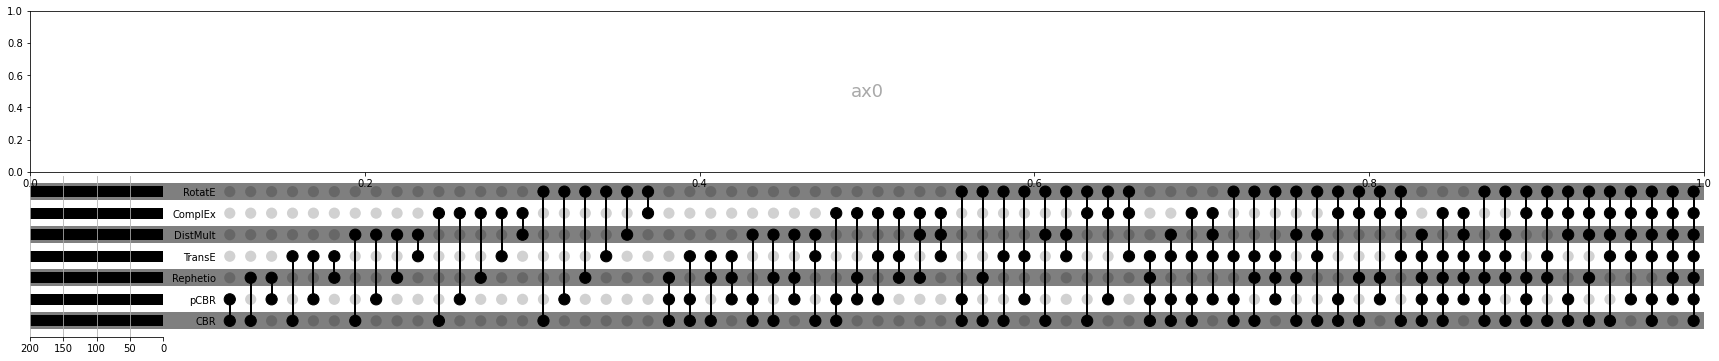

In [285]:
def annotate_axes(ax, text, fontsize=18):
    ax.text(
        0.5,
        0.5,
        text,
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=fontsize,
        color="darkgrey",
    )


fig = plt.figure(figsize=(30, 6), layout=None)
spec = fig.add_gridspec(14, 124)

ax0 = fig.add_subplot(spec[0:7, :])
annotate_axes(ax0, "ax0")

# annotate_axes(ax1_totals, 'ax1_totals')
ax1_shading = fig.add_subplot(
    spec[7:14, 0:124],
)
# annotate_axes(ax1_shading, 'ax1_shading')
ax1_matrix = fig.add_subplot(
    spec[7:14, 14:124],
    sharey=ax1_shading,
)
ax1_totals = fig.add_subplot(
    spec[7:14, 0:10],
    sharey=ax1_matrix,
)

m.plot_matrix(ax1_matrix)
m.plot_shading(ax1_shading)
m.plot_totals(ax1_totals)

# ax1_totals.set_subplotspec()

In [286]:
pd.concat([dfset1, dfset2]).index.nlevels

7

In [288]:
pd.concat([dfset1, dfset2]).index.to_frame()

CBR   pCBR Rephetio  \
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE                          
True  True  False    True   True     True    True     True   True    False   
                                             True     True   True    False   
            True     True   True     True    True     True   True     True   
      False False    False  False    False   False    True  False    False   
      True  False    False  False    True    True     True   True    False   
...                                                    ...    ...      ...   
False False False    False  False    False   True    False  False    False   
                                             True    False  False    False   
                                             True    False  False    False   
                                             True    False  False    False   
                                             True    False  False    False   

                                                    TransE DistMult ComplEx  \
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE                           
True  True  False    True   True     True    True     True     True    True   
                                             True     True     True    True   
            True     True   True     True    True     True     True    True   
      False False    False  False    False   False   False    False   False   
      True  False    False  False    True    True    False    False    True   
...                                                    ...      ...     ...   
False False False    False  False    False   True    False    False   False   
                                             True    False    False   False   
                                             True    False    False   False   
                                             True    False    False   False   
                                             True    False    False   False   

                                                    RotatE  
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE         
True  True  False    True   True     True    True     True  
                                             True     True  
            True     True   True     True    True     True  
      False False    False  False    False   False   False  
      True  False    False  False    True    True     True  
...                                                    ...  
False False False    False  False    False   True     True  
                                             True     True  
                                             True     True  
                                             True     True  
                                             True     True  

[939 rows x 7 columns]

In [290]:
inclusion = pd.concat([dfset1, dfset2]).index.to_frame().values
inclusion

array([[True, True, False, ..., True, True, True],
       [True, True, False, ..., True, True, True],
       [True, True, True, ..., True, True, True],
       ...,
       [False, False, False, ..., False, False, True],
       [False, False, False, ..., False, False, True],
       [False, False, False, ..., False, False, True]], dtype=object)

In [292]:
idx = np.flatnonzero(inclusion)
idx

array([   0,    1,    3, ..., 6558, 6565, 6572])

In [296]:
x = np.repeat(np.arange(len(pd.concat([dfset1, dfset2]))), 7)
y = np.tile(np.arange(7), len(pd.concat([dfset1, dfset2])))

In [297]:
x

array([  0,   0,   0, ..., 938, 938, 938])

In [298]:
y

array([0, 1, 2, ..., 4, 5, 6])

In [301]:
(pd.Series(y[idx], index=x[idx])).groupby(level=0).agg(["min", "max"])

min  max
0      0    6
1      0    6
2      0    6
3      0    0
4      0    6
..   ...  ...
934    6    6
935    6    6
936    6    6
937    6    6
938    6    6

[939 rows x 2 columns]

## Get overlap for each combination

In [302]:
def overlap(ls_combo: list) -> list:
    """
    Takes two or more series of lists in a list (ex [[[s],[e],[r],[1]],[[s],[e],[r],[2]]]) and returns the overlapping entities as a list
    """
    return list(set.intersection(*[set(a_ls) for a_ls in ls_combo]))


def overlap_count(ls_combo: list) -> int:
    """
    Takes two or more series of lists in a list and returns the overlapping count
    """
    return len(overlap(ls_combo))


def get_rank(to_rank: list, ls_combo: list) -> dict:
    """
    Gets rank of items in 'to_rank' from positions in 'ls_combo', a list of lists as a dict.

    ex
    get_rank(to_rank = ['DOID:1234'], ls_combo = [['DOID:1234'],[.,.,.,.,'DOID:1234'],[.,.,'DOID:1234']]) -> {'DOID:1234':[1,5,3]}
    """
    return {ent: [ls.index(ent) for ls in ls_combo] for ent in to_rank}


def avg_rank(to_rank: list, ls_combo: list) -> dict:
    """
    Gets the average rank of items in 'to_rank' from positions of entitiy in each list in 'ls_combo'
    """
    return {k: statistics.mean(v) for k, v in get_ranks(to_rank, ls_combo).items()}


def avg_rr(to_rank: list, ls_combo: list) -> dict:
    """
    Gets the average reciprocal rank of items in 'to_rank' from positions of the item in each list in 'ls_combo'
    """
    return {
        k: statistics.mean([1 / i for i in v])
        for k, v in get_ranks(to_rank, ls_combo).items()
    }

In [303]:
# get a list of tuples of all combinations of algorithm results
algos = ["CBR", "pCBR", "Rephetio", "TransE", "DistMult", "ComplEx", "RotatE"]
algo_combos = [
    j
    for i in [
        list(itertools.combinations(algos, combo_sz))
        for combo_sz in range(2, len(algos) + 1)
    ]
    for j in i
]

In [304]:
algo_combos

[('CBR', 'pCBR'),
 ('CBR', 'Rephetio'),
 ('CBR', 'TransE'),
 ('CBR', 'DistMult'),
 ('CBR', 'ComplEx'),
 ('CBR', 'RotatE'),
 ('pCBR', 'Rephetio'),
 ('pCBR', 'TransE'),
 ('pCBR', 'DistMult'),
 ('pCBR', 'ComplEx'),
 ('pCBR', 'RotatE'),
 ('Rephetio', 'TransE'),
 ('Rephetio', 'DistMult'),
 ('Rephetio', 'ComplEx'),
 ('Rephetio', 'RotatE'),
 ('TransE', 'DistMult'),
 ('TransE', 'ComplEx'),
 ('TransE', 'RotatE'),
 ('DistMult', 'ComplEx'),
 ('DistMult', 'RotatE'),
 ('ComplEx', 'RotatE'),
 ('CBR', 'pCBR', 'Rephetio'),
 ('CBR', 'pCBR', 'TransE'),
 ('CBR', 'pCBR', 'DistMult'),
 ('CBR', 'pCBR', 'ComplEx'),
 ('CBR', 'pCBR', 'RotatE'),
 ('CBR', 'Rephetio', 'TransE'),
 ('CBR', 'Rephetio', 'DistMult'),
 ('CBR', 'Rephetio', 'ComplEx'),
 ('CBR', 'Rephetio', 'RotatE'),
 ('CBR', 'TransE', 'DistMult'),
 ('CBR', 'TransE', 'ComplEx'),
 ('CBR', 'TransE', 'RotatE'),
 ('CBR', 'DistMult', 'ComplEx'),
 ('CBR', 'DistMult', 'RotatE'),
 ('CBR', 'ComplEx', 'RotatE'),
 ('pCBR', 'Rephetio', 'TransE'),
 ('pCBR', 'Rephetio

In [306]:
# per indication get number of overlapping answers for each st of algo

h_ls = list(combined_df.query('algo=="CBR"').h)
algo_combo_dict = dict()

for algos in tqdm(iterable=algo_combos, total=len(algo_combos)):
    overlap_items = list()
    algos_ls = list(algos)
    for compound in list(h_ls):
        filt_df = combined_df.query("h in @compound & algo in @algos_ls")
        overlap_items.append(overlap(list(filt_df.predicted_answers)))

    algo_combo_dict.update({algos: overlap_items})

100%|█████████████████████████████████████████████████████████████████████████████████| 120/120 [01:14<00:00,  1.61it/s]


In [307]:
algo_combo_dict

{('CBR',
  'pCBR'): [['DOID:6432',
   'DOID:3393',
   'DOID:10652',
   'DOID:60164',
   'DOID:0050855',
   'DOID:557',
   'DOID:784',
   'DOID:114',
   'DOID:3526',
   'DOID:1289',
   'DOID:5844',
   'DOID:1074',
   'DOID:12785',
   'MONDO:0007263',
   'DOID:7148',
   'MESH:D018487',
   'DOID:11503',
   'DOID:10591',
   'DOID:1826',
   'DOID:6000',
   'DOID:0060224',
   'DOID:10763'], ['DOID:0060224',
   'DOID:6432',
   'DOID:446',
   'DOID:0060173',
   'DOID:10763',
   'DOID:3312',
   'DOID:60674',
   'HP:0001681',
   'DOID:9970',
   'DOID:0110220',
   'DOID:9993',
   'DOID:1826',
   'DOID:12849',
   'DOID:6000'], ['DOID:4465',
   'DOID:1612',
   'DOID:10283',
   'MESH:D002471',
   'DOID:2394',
   'DOID:60164',
   'MESH:D056486',
   'DOID:1240',
   'DOID:9119',
   'DOID:3908',
   'DOID:11054'], [], ['DOID:5419',
   'DOID:7148',
   'DOID:14330',
   'DOID:1793',
   'MESH:D003921',
   'DOID:8398',
   'DOID:10603',
   'DOID:9970',
   'MESH:D064420',
   'DOID:3602',
   'DOID:1561',
   'DOI

In [308]:
# get length of overlapping predictions

overlap_len_algo_combo_dict = {
    i: [len(v2) for v2 in v] for i, v in algo_combo_dict.items()
}

In [360]:
# transform dictionary to dataframe

overlap_df = pd.DataFrame(
    {
        "algos": overlap_len_algo_combo_dict.keys(),
        "result": overlap_len_algo_combo_dict.values(),
    }
)
overlap_df["CBR"] = overlap_df.algos.apply(lambda x: "CBR" in set(x))
overlap_df["pCBR"] = overlap_df.algos.apply(lambda x: "pCBR" in set(x))
overlap_df["Rephetio"] = overlap_df.algos.apply(lambda x: "Rephetio" in set(x))
overlap_df["TransE"] = overlap_df.algos.apply(lambda x: "TransE" in set(x))
overlap_df["DistMult"] = overlap_df.algos.apply(lambda x: "DistMult" in set(x))
overlap_df["ComplEx"] = overlap_df.algos.apply(lambda x: "ComplEx" in set(x))
overlap_df["RotatE"] = overlap_df.algos.apply(lambda x: "RotatE" in set(x))

In [361]:
overlap_df

algos  \
0                                          (CBR, pCBR)   
1                                      (CBR, Rephetio)   
2                                        (CBR, TransE)   
3                                      (CBR, DistMult)   
4                                       (CBR, ComplEx)   
..                                                 ...   
115   (CBR, pCBR, Rephetio, DistMult, ComplEx, RotatE)   
116     (CBR, pCBR, TransE, DistMult, ComplEx, RotatE)   
117  (CBR, Rephetio, TransE, DistMult, ComplEx, Rot...   
118  (pCBR, Rephetio, TransE, DistMult, ComplEx, Ro...   
119  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   

                                                result    CBR   pCBR  \
0    [22, 14, 11, 0, 14, 0, 8, 16, 17, 15, 12, 5, 0...   True   True   
1    [17, 15, 26, 21, 21, 25, 31, 22, 24, 23, 25, 2...   True  False   
2    [36, 29, 12, 21, 18, 0, 23, 9, 13, 27, 41, 4, ...   True  False   
3    [16, 12, 2, 19, 13, 4, 19, 32, 19, 6, 12, 3, 4...   True  False   
4    [19, 7, 10, 14, 16, 2, 3, 8, 13, 4, 27, 0, 9, ...   True  False   
..                                                 ...    ...    ...   
115  [2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...   True   True   
116  [6, 3, 1, 0, 2, 0, 0, 1, 1, 0, 3, 0, 0, 0, 0, ...   True   True   
117  [2, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, ...   True  False   
118  [3, 2, 1, 0, 3, 1, 0, 1, 1, 0, 2, 0, 0, 1, 0, ...  False   True   
119  [2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...   True   True   

     Rephetio  TransE  DistMult  ComplEx  RotatE  
0       False   False     False    False   False  
1        True   False     False    False   False  
2       False    True     False    False   False  
3       False   False      True    False   False  
4       False   False     False     True   False  
..        ...     ...       ...      ...     ...  
115      True   False      True     True    True  
116     False    True      True     True    True  
117      True    True      True     True    True  
118      True    True      True     True    True  
119      True    True      True     True    True  

[120 rows x 9 columns]

In [362]:
# this for some reason isn't considered a multi indexed dataframe to be used for upsetplotting.
overlap_df2 = overlap_df.set_index(
    ["CBR", "pCBR", "Rephetio", "TransE", "DistMult", "ComplEx", "RotatE"]
)[["result"]]

In [363]:
overlap_df2.head()

result
CBR  pCBR  Rephetio TransE DistMult ComplEx RotatE                                                   
True True  False    False  False    False   False   [22, 14, 11, 0, 14, 0, 8, 16, 17, 15, 12, 5, 0...
     False True     False  False    False   False   [17, 15, 26, 21, 21, 25, 31, 22, 24, 23, 25, 2...
           False    True   False    False   False   [36, 29, 12, 21, 18, 0, 23, 9, 13, 27, 41, 4, ...
                    False  True     False   False   [16, 12, 2, 19, 13, 4, 19, 32, 19, 6, 12, 3, 4...
                           False    True    False   [19, 7, 10, 14, 16, 2, 3, 8, 13, 4, 27, 0, 9, ...

In [393]:
upsetplot.from_memberships(
    memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
    data=overlap_df,
).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4])

algos  \
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE                                                      
True  True  False    False  False    False   False                                         (CBR, pCBR)   
      False True     False  False    False   False                                     (CBR, Rephetio)   
            False    True   False    False   False                                       (CBR, TransE)   
                     False  True     False   False                                     (CBR, DistMult)   
                            False    True    False                                      (CBR, ComplEx)   
...                                                                                                ...   
      True  True     False  True     True    True     (CBR, pCBR, Rephetio, DistMult, ComplEx, RotatE)   
            False    True   True     True    True       (CBR, pCBR, TransE, DistMult, ComplEx, RotatE)   
      False True     True   True     True    True    (CBR, Rephetio, TransE, DistMult, ComplEx, Rot...   
False True  True     True   True     True    True    (pCBR, Rephetio, TransE, DistMult, ComplEx, Ro...   
True  True  True     True   True     True    True    (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   

                                                                                                result  \
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE                                                      
True  True  False    False  False    False   False   [22, 14, 11, 0, 14, 0, 8, 16, 17, 15, 12, 5, 0...   
      False True     False  False    False   False   [17, 15, 26, 21, 21, 25, 31, 22, 24, 23, 25, 2...   
            False    True   False    False   False   [36, 29, 12, 21, 18, 0, 23, 9, 13, 27, 41, 4, ...   
                     False  True     False   False   [16, 12, 2, 19, 13, 4, 19, 32, 19, 6, 12, 3, 4...   
                            False    True    False   [19, 7, 10, 14, 16, 2, 3, 8, 13, 4, 27, 0, 9, ...   
...                                                                                                ...   
      True  True     False  True     True    True    [2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...   
            False    True   True     True    True    [6, 3, 1, 0, 2, 0, 0, 1, 1, 0, 3, 0, 0, 0, 0, ...   
      False True     True   True     True    True    [2, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, ...   
False True  True     True   True     True    True    [3, 2, 1, 0, 3, 1, 0, 1, 1, 0, 2, 0, 0, 1, 0, ...   
True  True  True     True   True     True    True    [2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...   

                                                       CBR   pCBR  Rephetio  \
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE                           
True  True  False    False  False    False   False    True   True     False   
      False True     False  False    False   False    True  False      True   
            False    True   False    False   False    True  False     False   
                     False  True     False   False    True  False     False   
                            False    True    False    True  False     False   
...                                                    ...    ...       ...   
      True  True     False  True     True    True     True   True      True   
            False    True   True     True    True     True   True     False   
      False True     True   True     True    True     True  False      True   
False True  True     True   True     True    True    False   True      True   
True  True  True     True   True     True    True     True   True      True   

                                                     TransE  DistMult  \
CBR   pCBR  Rephetio TransE DistMult ComplEx RotatE                     
True  True  False    False  False    False   False    False     False   
      False True     False  False    False   False    False     False   
            False  

In [394]:
n = upsetplot2(
    data=upsetplot.from_memberships(
        memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
        data=overlap_df,
    ).reorder_levels(order=[0, 6, 3, 5, 2, 1, 4]),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
)

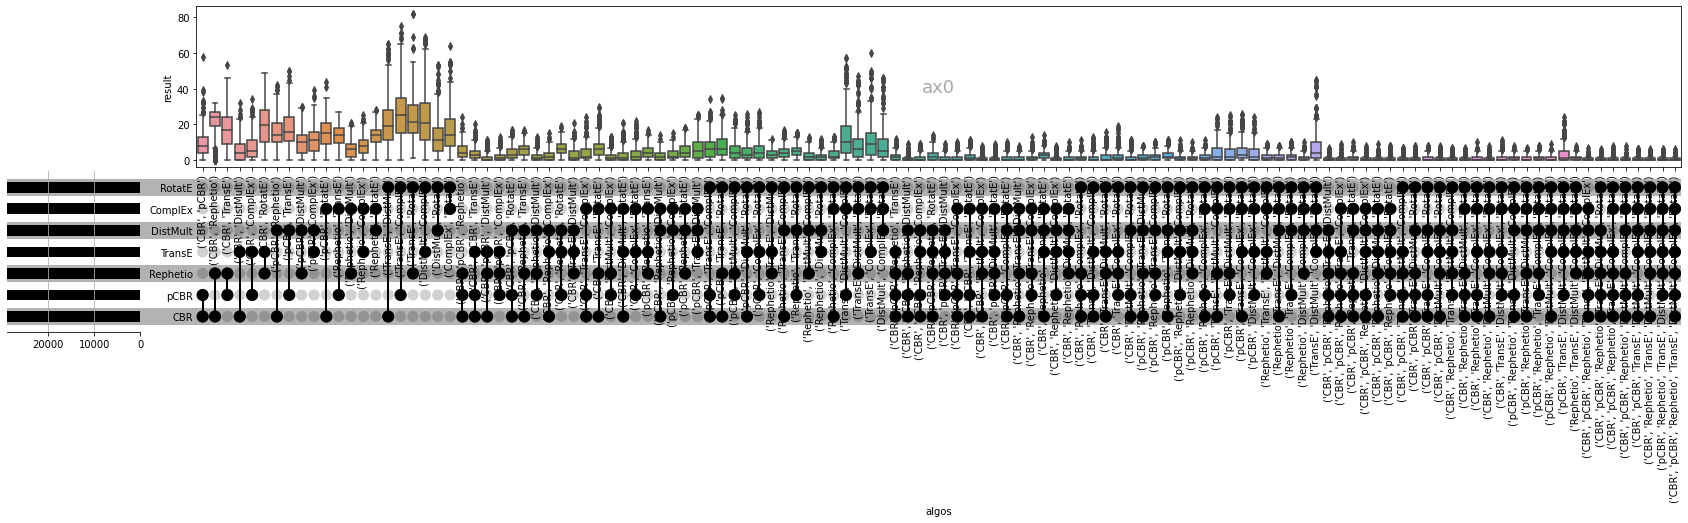

In [414]:
# gray annotation for axes
def annotate_axes(ax, text, fontsize=18):
    ax.text(
        0.5,
        0.5,
        text,
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=fontsize,
        color="darkgrey",
    )


# upset plot
n = upsetplot2(
    data=(
        upset_df := upsetplot.from_memberships(
            memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
            data=overlap_df,
        )
        .reorder_levels(order=[0, 6, 3, 5, 2, 1, 4])
        .explode("result")
    ),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
)

# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)
spec = fig.add_gridspec(14, 124)

ax0 = fig.add_subplot(spec[0:7, 14:124])
annotate_axes(ax0, "ax0")

sns.boxplot(data=upset_df, x="algos", y="result", ax=ax0)
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90)


# annotate_axes(ax1_totals, 'ax1_totals')
ax1_shading = fig.add_subplot(
    spec[7:14, 0:124],
)
# annotate_axes(ax1_shading, 'ax1_shading')
ax1_matrix = fig.add_subplot(spec[7:14, 14:124], sharey=ax1_shading, sharex=ax0)
ax1_totals = fig.add_subplot(
    spec[7:14, 0:10],
    sharey=ax1_matrix,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
n.plot_totals(ax1_totals)

# ax1_totals.set_subplotspec()

In [437]:
# get a dictionary to rerank the indicies
order = pd.DataFrame(n.intersections).reset_index()

tup_ls = list()
for i in range(0, order.shape[0], 1):
    als = list()
    for algo in ["CBR", "pCBR", "Rephetio", "TransE", "DistMult", "ComplEx", "RotatE"]:
        if order[algo].iloc[i]:
            als.append(algo)
    tup_ls.append(tuple(als))

order["algos"] = tup_ls
order["ind"] = [i for i in range(0, order.shape[0])]

In [440]:
order_algo_dict = dict(zip(order["algos"], order["ind"]))

In [443]:
upset_df2 = upset_df[["algos", "result"]]
upset_df2["ind"] = upset_df2.algos.apply(lambda x: order_algo_dict[x])
upset_df2

/tmp/ipykernel_469220/790975517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upset_df2['ind'] = upset_df2.algos.apply(lambda x: order_algo_dict[x])


algos  \
CBR  pCBR Rephetio TransE DistMult ComplEx RotatE                                                      
True True False    False  False    False   False                                         (CBR, pCBR)   
                                           False                                         (CBR, pCBR)   
                                           False                                         (CBR, pCBR)   
                                           False                                         (CBR, pCBR)   
                                           False                                         (CBR, pCBR)   
...                                                                                              ...   
          True     True   True     True    True    (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
                                           True    (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
                                           True    (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
                                           True    (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
                                           True    (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   

                                                  result  ind  
CBR  pCBR Rephetio TransE DistMult ComplEx RotatE              
True True False    False  False    False   False      22    0  
                                           False      14    0  
                                           False      11    0  
                                           False       0    0  
                                           False      14    0  
...                                                  ...  ...  
          True     True   True     True    True        0  119  
                                           True        0  119  
                                           True        1  119  
                                           True        0  119  
                                           True        1  119  

[55200 rows x 3 columns]

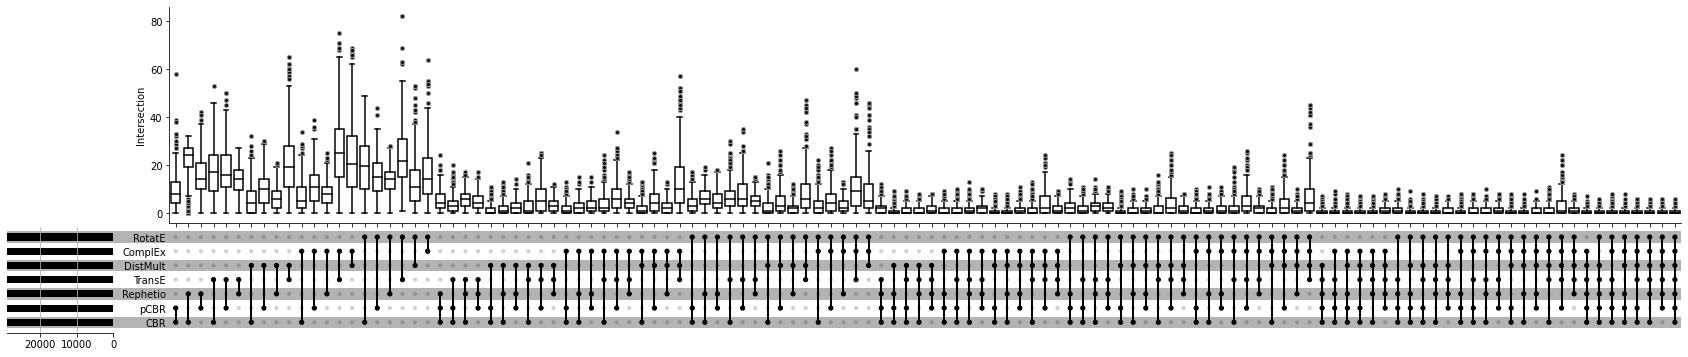

In [506]:
# Overlaps for all 120 algorithm combinations of 100 predictions of 460 indications... 5.52 million vs 55,200 rows?

# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 12

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.boxplot(
    data=upset_df2,
    x="ind",
    y="result",
    color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    medianprops=dict(color="black"),
    boxprops=dict(facecolor="none", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=4),
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Intersection",
)
sns.despine(ax=ax0)

n = upsetplot2(
    data=(
        upset_df := upsetplot.from_memberships(
            memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
            data=overlap_df,
        )
        .reorder_levels(order=[0, 6, 3, 5, 2, 1, 4])
        .explode("result")
    ),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
n.plot_totals(ax1_totals)

## get true answer from overlaps (if they exist)
* and count it!

In [ ]:
# each combo entry is 460 x 100 predictions
# total size is 120 x 460 x n<100
algo_combo_dict  # dictionary of overlapping entities per combo

In [513]:
# length of 460
true_answers_ls = list(combined_df.query('algo=="CBR"')["true_t"])

In [517]:
# right now the function get sa given id and assigns a rank list to that specific ID. This is more useful in the context of looking at specific predictions performance
# we are more interested in what ranks are the true answers in a given set of predictions, therefore this function is moot


# need a list of true answers, a list of predictions -> positions of those true answers (if they exist) in the list of predictions


def get_rank(to_rank: list, ls_combo: list) -> list:
    """
    Gets rank of items in 'to_rank' from positions in 'ls_combo', a list of lists, and returns the ranked item and its rank as two lists .

    ex
    get_rank(to_rank = ['DOID:1234','DOID:4444','DOID:02'], ls_combo = [['DOID:1234'],[.,.,.,.,'DOID:1234'],[.,.,'DOID:65432']]) -> ['DOID:1234','DOID:02'], [1,5]
    """
    rank_ls = list()
    ent_ls = list()

    for ent in to_rank:
        try:
            rank = ls_combo.index(ent)
            rank_ls.append(rank)
            ent_ls.append(ent)
        except:
            next

    return (ent_ls, rank_ls)

In [518]:
# Generate a dictionary of algo combos to (true answer, ranks)
## key is the combo of algo to overlaps
## val is a list (460 items) of list (n overlaps)
## these ranks are pretty meaningless because they represent an unsorted intersection between multiple entites.
## however the functions can be repurposed later
algo_combo_rank_dict = {
    key: [
        get_rank(to_rank=true_answers_ls[ind], ls_combo=preds)
        for ind, preds in enumerate(val)
    ]
    for key, val in algo_combo_dict.items()
}

In [528]:
algo_combo_rank_dict[("CBR", "pCBR")]

[(['DOID:6432', 'DOID:10591', 'DOID:10763'], [0, 17, 21]),
 (['DOID:6432', 'DOID:10763'], [1, 4]),
 (['DOID:11054'], [10]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:9352'], [4]),
 (['DOID:9352'], [4]),
 (['DOID:10825'], [5]),
 (['DOID:10763'], [6]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:1793', 'DOID:2394', 'DOID:3908'], [2, 9, 16]),
 (['DOID:1793', 'DOID:2394', 'DOID:3908'], [2, 9, 16]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:3963'], [3]),
 (['DOID:3963'], [3]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:14330'], [2]),
 (['DOID:10763'], [1]),
 (['DOID:3376'], [10]),
 (['DOID:3376'], [10]),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:9352'], [54]),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:10763'], [3]),
 ([], []),
 (['DOID:9119'], [15]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:10763'], [2]),
 ([], []),
 ([], []),
 ([

In [520]:
# re-rank your true answers if there is more than 1 item in each list per tuple
# use this later
def rerank_ans(ranks: list) -> list:
    """
    Reranks a list of values based on the number of entities preceding the rank
    ex
    [24,4,15] -> [22,4,14]
    24 is decreased by 2 because 2 ranks precede it
    14 is decreased by 1 because 1 rank precedes it
    4 is not decreased at all because nothing precedes it
    """
    if len(ranks) <= 1:
        # list is empty, or 1
        return ranks
    else:
        rank_rerank_dict = {rank: rank - ind for ind, rank in enumerate(sorted(ranks))}
        new_ranks = [rank_rerank_dict[rank] for rank in ranks]
        return new_ranks

In [525]:
assert rerank_ans([]) == []
assert rerank_ans(
    [
        1,
    ]
) == [1]
assert rerank_ans([24, 4, 15]) == [22, 4, 14]

In [527]:
# rerank the original rank dictionary to account for multiple correct answers
reranked_algo_combo_rank_dict = {
    algo_combo: [(trues, rerank_ans(ranks)) for trues, ranks in ls_ranks]
    for algo_combo, ls_ranks in algo_combo_rank_dict.items()
}
reranked_algo_combo_rank_dict[("CBR", "pCBR")]

[(['DOID:6432', 'DOID:10591', 'DOID:10763'], [0, 16, 19]),
 (['DOID:6432', 'DOID:10763'], [1, 3]),
 (['DOID:11054'], [10]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:9352'], [4]),
 (['DOID:9352'], [4]),
 (['DOID:10825'], [5]),
 (['DOID:10763'], [6]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:1793', 'DOID:2394', 'DOID:3908'], [2, 8, 14]),
 (['DOID:1793', 'DOID:2394', 'DOID:3908'], [2, 8, 14]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:3963'], [3]),
 (['DOID:3963'], [3]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:14330'], [2]),
 (['DOID:10763'], [1]),
 (['DOID:3376'], [10]),
 (['DOID:3376'], [10]),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:9352'], [54]),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:10763'], [3]),
 ([], []),
 (['DOID:9119'], [15]),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 ([], []),
 (['DOID:10763'], [2]),
 ([], []),
 ([], []),
 ([

In [529]:
# Turn ranking dict into a dataframe
# how many are empty?

true_overlap_dfls = list()
for key, ls_ranks in reranked_algo_combo_rank_dict.items():
    key_ls = [key for i in range(0, len(ls_ranks))]
    overlap_trues = [i[0] for i in ls_ranks]
    trues_ranks = [i[1] for i in ls_ranks]
    true_overlap_dfls.append(
        pd.DataFrame(
            {"algos": key_ls, "overlap_trues": overlap_trues, "trues_rank": trues_ranks}
        )
    )

In [531]:
trues_overlap_df = pd.concat(true_overlap_dfls)

In [532]:
trues_overlap_df

algos  \
0                                          (CBR, pCBR)   
1                                          (CBR, pCBR)   
2                                          (CBR, pCBR)   
3                                          (CBR, pCBR)   
4                                          (CBR, pCBR)   
..                                                 ...   
455  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
456  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
457  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
458  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
459  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   

                           overlap_trues   trues_rank  
0    [DOID:6432, DOID:10591, DOID:10763]  [0, 16, 19]  
1                [DOID:6432, DOID:10763]       [1, 3]  
2                           [DOID:11054]         [10]  
3                                     []           []  
4                                     []           []  
..                                   ...          ...  
455                                   []           []  
456                                   []           []  
457                                   []           []  
458                                   []           []  
459                          [DOID:9352]          [0]  

[55200 rows x 3 columns]

In [541]:
# get lengths of 'overlap_trues'. can probably plot on the same axes as the original overlap
# but hard to see and stagger it so let's not do that
trues_overlap_df["trues_rank_len"] = trues_overlap_df.trues_rank.apply(lambda x: len(x))
len_trues_overlap_df = trues_overlap_df.query("trues_rank_len>0")
len_trues_overlap_df["ind"] = len_trues_overlap_df.algos.apply(
    lambda x: order_algo_dict[x]
)

/tmp/ipykernel_469220/855458593.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  len_trues_overlap_df["ind"] = len_trues_overlap_df.algos.apply(lambda x: order_algo_dict[x])


In [542]:
len_trues_overlap_df

algos  \
0                                          (CBR, pCBR)   
1                                          (CBR, pCBR)   
2                                          (CBR, pCBR)   
7                                          (CBR, pCBR)   
8                                          (CBR, pCBR)   
..                                                 ...   
442  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
443  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
448  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
453  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
459  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   

                           overlap_trues   trues_rank  trues_rank_len  ind  
0    [DOID:6432, DOID:10591, DOID:10763]  [0, 16, 19]               3    0  
1                [DOID:6432, DOID:10763]       [1, 3]               2    0  
2                           [DOID:11054]         [10]               1    0  
7                            [DOID:9352]          [4]               1    0  
8                            [DOID:9352]          [4]               1    0  
..                                   ...          ...             ...  ...  
442                          [DOID:2841]          [0]               1  119  
443                          [DOID:9970]          [0]               1  119  
448                         [DOID:10763]          [0]               1  119  
453                         [DOID:10763]          [0]               1  119  
459                          [DOID:9352]          [0]               1  119  

[19210 rows x 5 columns]

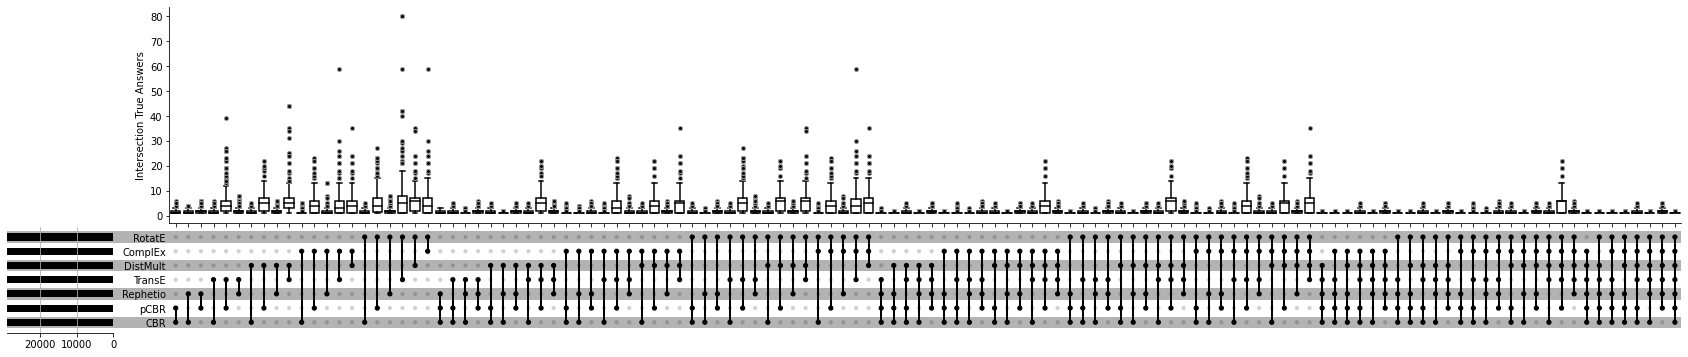

In [544]:
# number of trues per algo intersection
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 12

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)

# box plot
sns.boxplot(
    data=len_trues_overlap_df,
    x="ind",
    y="trues_rank_len",
    color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    medianprops=dict(color="black"),
    boxprops=dict(facecolor="none", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=4),
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Intersection True Answers",
)
sns.despine(ax=ax0)
n = upsetplot2(
    data=(
        upset_df := upsetplot.from_memberships(
            memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
            data=overlap_df,
        )
        .reorder_levels(order=[0, 6, 3, 5, 2, 1, 4])
        .explode("result")
    ),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
n.plot_totals(ax1_totals)

### Calculate Trues as a percentage of total overlap

In [552]:
trues_overlap_df["overlaps"] = list(
    overlap_df[["algos", "result"]].explode("result")["result"]
)
trues_overlap_df["true_divide_overlap"] = (
    trues_overlap_df["trues_rank_len"] / trues_overlap_df["overlaps"]
)
trues_overlap_df = trues_overlap_df.dropna()
trues_overlap_df["ind"] = trues_overlap_df.algos.apply(lambda x: order_algo_dict[x])

In [557]:
trues_overlap_df

algos  \
0                                          (CBR, pCBR)   
1                                          (CBR, pCBR)   
2                                          (CBR, pCBR)   
4                                          (CBR, pCBR)   
6                                          (CBR, pCBR)   
..                                                 ...   
449  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
451  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
453  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
457  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   
459  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   

                           overlap_trues   trues_rank  trues_rank_len  \
0    [DOID:6432, DOID:10591, DOID:10763]  [0, 16, 19]               3   
1                [DOID:6432, DOID:10763]       [1, 3]               2   
2                           [DOID:11054]         [10]               1   
4                                     []           []               0   
6                                     []           []               0   
..                                   ...          ...             ...   
449                                   []           []               0   
451                                   []           []               0   
453                         [DOID:10763]          [0]               1   
457                                   []           []               0   
459                          [DOID:9352]          [0]               1   

     overlaps  true_divide_overlap  ind  
0          22             0.136364    0  
1          14             0.142857    0  
2          11             0.090909    0  
4          14             0.000000    0  
6           8             0.000000    0  
..        ...                  ...  ...  
449         1             0.000000  119  
451         1             0.000000  119  
453         1             1.000000  119  
457         1             0.000000  119  
459         1             1.000000  119  

[36471 rows x 7 columns]

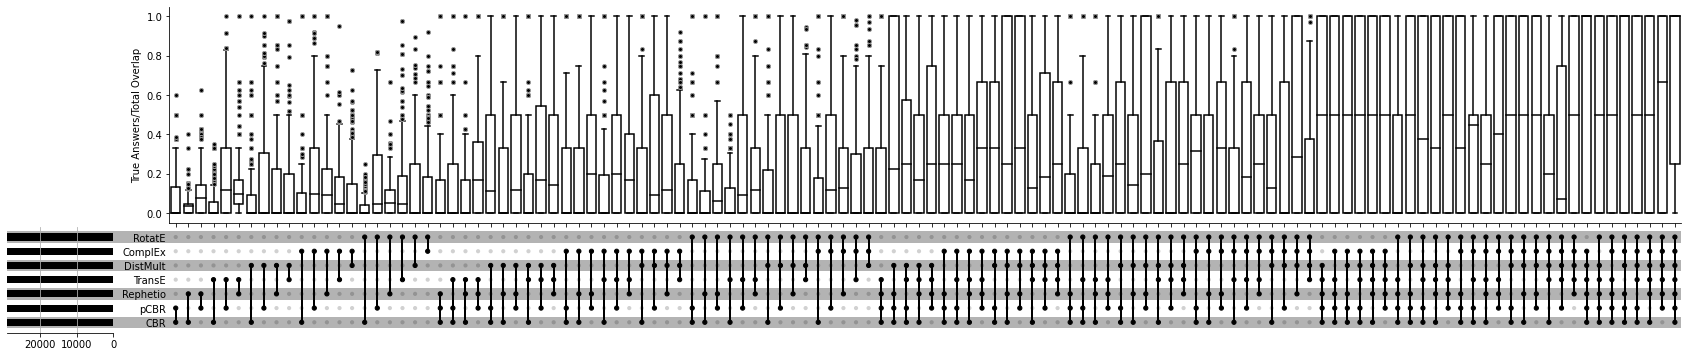

In [558]:
# number of trues per algo divided by total intersection
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 12

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)

# box plot
sns.boxplot(
    data=trues_overlap_df,
    x="ind",
    y="true_divide_overlap",
    color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    medianprops=dict(color="black"),
    boxprops=dict(facecolor="none", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=4),
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="True Answers/Total Overlap",
)
sns.despine(ax=ax0)
n = upsetplot2(
    data=(
        upset_df := upsetplot.from_memberships(
            memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
            data=overlap_df,
        )
        .reorder_levels(order=[0, 6, 3, 5, 2, 1, 4])
        .explode("result")
    ),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
n.plot_totals(ax1_totals)

In [536]:
# drop empty lists after expanding 'trues rank'
trues_overlap_df2 = trues_overlap_df.explode("trues_rank").dropna()
# add 1 to the rank so it isn't indexed at 0
trues_overlap_df2["trues_rank"] = trues_overlap_df2["trues_rank"].apply(lambda x: x + 1)
# setup the index for each algo combo to correspond to the proper matrix plot
trues_overlap_df2["ind"] = trues_overlap_df2.algos.apply(lambda x: order_algo_dict[x])

In [538]:
trues_overlap_df2.head()

algos                        overlap_trues  trues_rank  ind
0  (CBR, pCBR)  [DOID:6432, DOID:10591, DOID:10763]           1    0
0  (CBR, pCBR)  [DOID:6432, DOID:10591, DOID:10763]          17    0
0  (CBR, pCBR)  [DOID:6432, DOID:10591, DOID:10763]          20    0
1  (CBR, pCBR)              [DOID:6432, DOID:10763]           2    0
1  (CBR, pCBR)              [DOID:6432, DOID:10763]           4    0

### Plot upsetplot of the distribution of true ranks from each overlapping algo

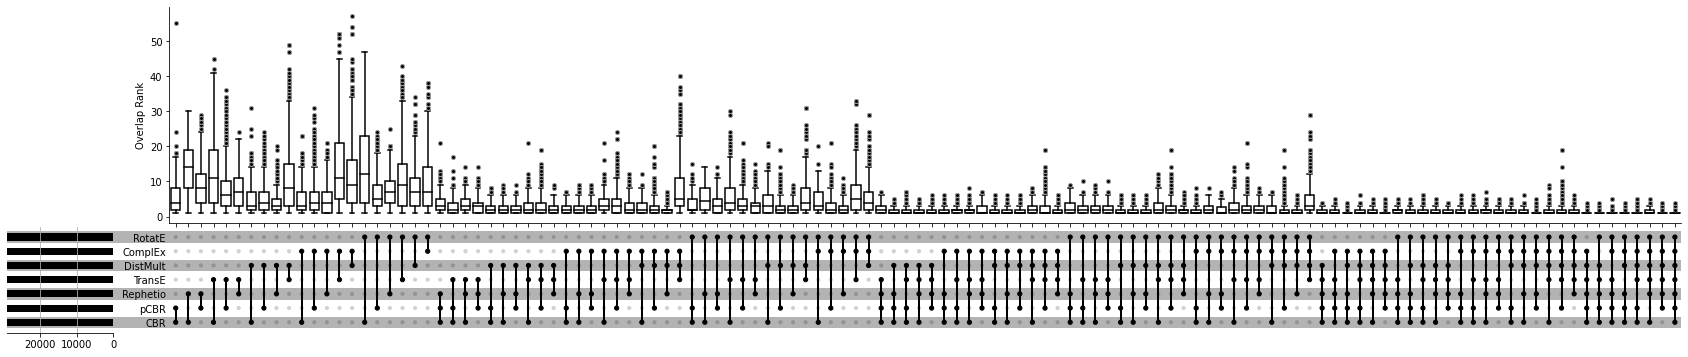

In [540]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 12

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)

# box plot
sns.boxplot(
    data=trues_overlap_df2,
    x="ind",
    y="trues_rank",
    color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    medianprops=dict(color="black"),
    boxprops=dict(facecolor="none", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=4),
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Overlap Rank",
)
sns.despine(ax=ax0)
n = upsetplot2(
    data=(
        upset_df := upsetplot.from_memberships(
            memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
            data=overlap_df,
        )
        .reorder_levels(order=[0, 6, 3, 5, 2, 1, 4])
        .explode("result")
    ),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
n.plot_totals(ax1_totals)

* Thinking about it, would be nice to have a trend line in the background or a seperate figure showing the number of overlaps -> number of true indication 

## Make a figure with average rank of overlapping entities
* probably going to look the same as the overlap.
* The best representation of what it should look like is probably as a scatter plot
    * color coded by: overlap (a method of filtering) shows the true hits (color coded by )

In [610]:
j = [1, 17, 3]

In [611]:
sorted(j)

[1, 3, 17]

In [613]:
sorted(j).index(17)

2

In [614]:
[i + 1 - sorted(j).index(i) for i in j if len(j) > 1]

[2, 16, 3]

In [759]:
# previously wrote a function get_rank, but needs a try, except statement to account for objects not exist in a list
# also looking for an item in a list vs item in a list of lists
def get_rank(to_rank: list, predict_ls: list, filter_rank: bool = False) -> dict:
    """
    Gets rank of items in 'to_rank' from positions in 'ls_combo', a list of lists as a dict. The parameter `filter_rank` applies only for when multiple true answers are known, otherwise should default to False.

    ex
    get_rank(to_rank = ['DOID:1234'], predict_ls = [.,.,.,.,'DOID:1234'], filter = False) -> {'DOID:1234':5}
    """
    rank_dict = dict()
    for ent in to_rank:
        try:
            rank_dict.update({ent: predict_ls.index(ent) + 1})
        except:
            next

    if filter_rank:
        # iterate through the dict, subtract number of ranks prior to rank
        vals = list(rank_dict.values())
        rank_dict = dict(
            zip(rank_dict.keys(), [val - sorted(vals).index(val) for val in vals])
        )

    return rank_dict

In [760]:
combined_df2 = combined_df[
    ["h", "predicted_answers", "true_t", "algo"]
].drop_duplicates(["h", "algo"])
combined_df2

h  \
0                         CHEBI:135735   
1                         CHEBI:135738   
2                         CHEBI:135876   
3                         CHEBI:135923   
4                         CHEBI:135925   
...                                ...   
3214  IKEY:COCFEDIXXNGUNL-RFKWWTKHSA-N   
3215  IKEY:CSRKRWYVFHQLNJ-UIEAZXIASA-N   
3217  IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N   
3218  IKEY:XYGBKMMCQDZQOZ-UHFFFAOYSA-M   
3219  IKEY:YHIUPZFKHZTLSH-LXYIGGQGSA-N   

                                      predicted_answers  \
0     [DOID:3393, DOID:6000, DOID:10763, DOID:3683, ...   
1     [HP:0000006, HP:0000007, HP:0001425, HP:000142...   
2     [DOID:0050861, DOID:10283, MESH:D008106, DOID:...   
3     [DOID:684, MESH:D008106, DOID:60052, MESH:D056...   
4     [DOID:60080, DOID:60075, DOID:1612, DOID:60164...   
...                                                 ...   
3214  [DOID:9744, DOID:446, DOID:10603, MESH:D011297...   
3215  [DOID:11150, GO:0016020, GO:0016021, NCBITaxon...   
3217  [WD:Q53910821, WD:Q4677939, MESH:D015472, WD:Q...   
3218  [GO:0016853, GO:0046872, NCBITaxon:5833, GO:00...   
3219  [DOID:9352, DOID:10182, DOID:11712, DOID:1837,...   

                                                 true_t    algo  
0     [DOID:6432, DOID:10825, DOID:10591, DOID:10824...     CBR  
1     [DOID:6432, DOID:10825, DOID:10591, DOID:10824...     CBR  
2     [DOID:11811, DOID:11814, DOID:11812, DOID:1159...     CBR  
3                                          [DOID:14499]     CBR  
4                             [DOID:1094, MESH:D056912]     CBR  
...                                                 ...     ...  
3214                                        [DOID:9744]  RotatE  
3215  [DOID:1066, DOID:1070, DOID:13544, DOID:1067, ...  RotatE  
3217  [DOID:0060318, DOID:8761, DOID:8864, WD:Q11101...  RotatE  
3218                                        [DOID:8986]  RotatE  
3219     [DOID:10182, DOID:11712, DOID:1837, DOID:9352]  RotatE  

[2254 rows x 4 columns]

In [761]:
combined_df2["rank_pos"] = [
    get_rank(
        val,
        list(combined_df2.predicted_answers)[ind],
    )
    for ind, val in enumerate(list(combined_df2.true_t))
]

In [762]:
combined_df2.head()

h                                  predicted_answers  \
0  CHEBI:135735  [DOID:3393, DOID:6000, DOID:10763, DOID:3683, ...   
1  CHEBI:135738  [HP:0000006, HP:0000007, HP:0001425, HP:000142...   
2  CHEBI:135876  [DOID:0050861, DOID:10283, MESH:D008106, DOID:...   
3  CHEBI:135923  [DOID:684, MESH:D008106, DOID:60052, MESH:D056...   
4  CHEBI:135925  [DOID:60080, DOID:60075, DOID:1612, DOID:60164...   

                                              true_t algo  \
0  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  CBR   
1  [DOID:6432, DOID:10825, DOID:10591, DOID:10824...  CBR   
2  [DOID:11811, DOID:11814, DOID:11812, DOID:1159...  CBR   
3                                       [DOID:14499]  CBR   
4                          [DOID:1094, MESH:D056912]  CBR   

                                            rank_pos  
0  {'DOID:6432': 22, 'DOID:10591': 13, 'DOID:1076...  
1                 {'DOID:6432': 99, 'DOID:10763': 8}  
2                                 {'DOID:11054': 93}  
3                                 {'DOID:14499': 80}  
4                                                 {}

In [763]:
# get average ranks to a dict
algos_2_comp_rank_ls = dict()
for algos in tqdm(iterable=algo_combos, total=len(algo_combos)):
    filt_df = combined_df2.query("algo in @algos")

    # for each compound in test, get a list of intersecting ranks
    comp_list_rank = list()
    for compound in list(set(h_ls)):
        comp_filt_df = filt_df.query("h==@compound")
        intersect_items = set.intersection(
            *map(set, [list(ds.keys()) for ds in list(comp_filt_df.rank_pos)])
        )
        if len(intersect_items) >= 1:
            # for each intersecting rank get the ranks of the item
            comp_list_rank.append(
                {
                    compound: {
                        uniq_comp: [
                            rank_dict[uniq_comp]
                            for rank_dict in list(comp_filt_df.rank_pos)
                        ]
                        for uniq_comp in list(intersect_items)
                    }
                }
            )

    # update a dictionary with keys of the combination and the compound to disease rank predictions
    algos_2_comp_rank_ls.update({algos: comp_list_rank})

100%|███████████████████████████████████████████████████████████████| 120/120 [00:33<00:00,  3.54it/s]


In [764]:
# probably need to figure out how to append the compound to the list, otherwise its pretty confusing what's going on
algos_2_comp_rank_ls[("CBR", "pCBR")]

[{'CHEBI:3647': {'DOID:5419': [55, 19]}},
 {'CHEBI:6847': {'DOID:10763': [2, 2]}},
 {'CHEBI:9122': {'DOID:5419': [19, 54]}},
 {'CHEBI:3698': {'DOID:10763': [6, 2]}},
 {'CHEBI:4509': {'DOID:7148': [39, 7]}},
 {'IKEY:DYLUUSLLRIQKOE-UHFFFAOYSA-N': {'DOID:0060318': [16, 6]}},
 {'CHEBI:3181': {'DOID:14330': [53, 2]}},
 {'CHEBI:65353': {'DOID:9970': [23, 3]}},
 {'CHEBI:50924': {'DOID:4465': [55, 27],
   'DOID:3963': [96, 2],
   'DOID:4450': [56, 5]}},
 {'CHEBI:5556': {'DOID:10825': [83, 5], 'DOID:10763': [2, 1]}},
 {'CHEBI:94615': {'DOID:2841': [78, 1]}},
 {'CHEBI:72564': {'DOID:1319': [96, 87], 'DOID:3068': [92, 52]}},
 {'CHEBI:585948': {'DOID:10763': [11, 3]}},
 {'CHEBI:175901': {'DOID:2394': [39, 4],
   'DOID:3908': [46, 13],
   'DOID:1793': [34, 15]}},
 {'CHEBI:8067': {'DOID:9970': [22, 22]}},
 {'CHEBI:48811': {'DOID:7148': [47, 19]}},
 {'CHEBI:3756': {'DOID:1824': [73, 1], 'DOID:1826': [13, 2]}},
 {'CHEBI:4728': {'DOID:9675': [14, 6]}},
 {'CHEBI:63620': {'DOID:14330': [4, 2]}},
 {'CHEBI

In [765]:
# 186 compounds from the test set have predictions with both CBR and pCBR methods
len(algos_2_comp_rank_ls[("CBR", "pCBR")])

127

In [766]:
# 322 unique total compound predictions
len(set(combined_df2.h))

322

## misc work on extracting ranks

In [641]:
# get average and average of the reciprocal ranks per ind

algos_2_comp_avg_rank = dict()
algos_2_comp_rr = dict()

for algos, res_ls in algos_2_comp_rank_ls.items():

    avg_ls = list()
    rr_ls = list()

    for dicts in res_ls:
        avg_ls.append(
            {comp: (sum(ranks) / len(ranks)) for comp, ranks in dicts.items()}
        )
        rr_ls.append(
            {
                comp: (sum([1 / rank for rank in ranks]) / len(ranks))
                for comp, ranks in dicts.items()
            }
        )

    algos_2_comp_avg_rank.update({algos: avg_ls})
    algos_2_comp_rr.update({algos: rr_ls})

In [648]:
# flatten the dicts. Previously didn't flatten because I wanted to preserve the formatting

algos_2_comp_avg_rank_flat = dict()
for algos, res_ls in algos_2_comp_avg_rank.items():
    algos_2_comp_avg_rank_flat.update(
        {algos: [v for dicts in res_ls for k, v in dicts.items()]}
    )

algos_2_comp_rr_flat = dict()
for algos, res_ls in algos_2_comp_rr.items():
    algos_2_comp_rr_flat.update(
        {algos: [v for dicts in res_ls for v in dicts.values()]}
    )

In [658]:
# combine into a dataframe

rank_df = pd.DataFrame(
    {
        "algos": algos_2_comp_avg_rank_flat.keys(),
        "Average": algos_2_comp_avg_rank_flat.values(),
        "Reciprocal": algos_2_comp_rr_flat.values(),
    }
)

In [660]:
true_rank_df = rank_df.melt(id_vars="algos", value_vars=["avg_rank", "rr"])
true_rank_df["ind"] = True

In [662]:
true_rank_df

algos  variable  \
0                                          (CBR, pCBR)  avg_rank   
1                                      (CBR, Rephetio)  avg_rank   
2                                        (CBR, TransE)  avg_rank   
3                                      (CBR, DistMult)  avg_rank   
4                                       (CBR, ComplEx)  avg_rank   
..                                                 ...       ...   
235   (CBR, pCBR, Rephetio, DistMult, ComplEx, RotatE)        rr   
236     (CBR, pCBR, TransE, DistMult, ComplEx, RotatE)        rr   
237  (CBR, Rephetio, TransE, DistMult, ComplEx, Rot...        rr   
238  (pCBR, Rephetio, TransE, DistMult, ComplEx, Ro...        rr   
239  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...        rr   

                                                 value   ind  
0    [10.5, 7.0, 2.5, 50.0, 4.5, 52.5, 5.5, 14.0, 6...  True  
1    [2.0, 4.5, 59.0, 40.5, 5.5, 14.5, 1.5, 1.0, 22...  True  
2    [12.5, 8.5, 4.0, 51.0, 5.0, 50.5, 41.0, 7.0, 1...  True  
3    [14.0, 10.0, 5.5, 65.0, 16.0, 83.5, 5.0, 15.5,...  True  
4    [11.0, 7.0, 2.5, 51.0, 5.5, 55.0, 5.0, 14.0, 1...  True  
..                                                 ...   ...  
235  [0.46527777777777773, 0.5833333333333334, 0.04...  True  
236  [0.34027777777777773, 0.2625, 0.33194444444444...  True  
237  [0.4152777777777778, 0.5, 0.051764955182886874...  True  
238  [0.33194444444444443, 0.4430555555555556, 0.33...  True  
239  [0.42738095238095236, 0.5714285714285714, 0.05...  True  

[240 rows x 4 columns]

## Get indication ranks

In [767]:
ind_rank_df = pd.DataFrame(
    {
        "algos": [
            algo
            for algo, comps in algos_2_comp_rank_ls.items()
            for dicts in comps
            for d in dicts.keys()
        ],
        "compounds": [
            d
            for algo, comps in algos_2_comp_rank_ls.items()
            for dicts in comps
            for d in dicts.keys()
        ],
        "ind_overlap": [
            d
            for algo, comps in algos_2_comp_rank_ls.items()
            for dicts in comps
            for d in dicts.values()
        ],
    }
)

In [768]:
ind_rank_df

algos    compounds  \
0                                            (CBR, pCBR)   CHEBI:3647   
1                                            (CBR, pCBR)   CHEBI:6847   
2                                            (CBR, pCBR)   CHEBI:9122   
3                                            (CBR, pCBR)   CHEBI:3698   
4                                            (CBR, pCBR)   CHEBI:4509   
...                                                  ...          ...   
15219  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:5959   
15220  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:7735   
15221  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8245   
15222  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:48416   
15223  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:3128   

                                      ind_overlap  
0                         {'DOID:5419': [55, 19]}  
1                          {'DOID:10763': [2, 2]}  
2                         {'DOID:5419': [19, 54]}  
3                          {'DOID:10763': [6, 2]}  
4                          {'DOID:7148': [39, 7]}  
...                                           ...  
15219      {'DOID:10763': [5, 56, 1, 8, 9, 4, 1]}  
15220  {'DOID:5419': [30, 19, 1, 22, 73, 17, 45]}  
15221      {'DOID:2841': [7, 1, 2, 4, 18, 1, 12]}  
15222     {'DOID:10763': [11, 28, 1, 7, 7, 9, 3]}  
15223      {'DOID:10763': [1, 3, 1, 4, 32, 7, 1]}  

[15224 rows x 3 columns]

## Get all overlapping ranks

In [769]:
# get the rank of all overlapping entities
algos_2_overlap = dict()

for algos in tqdm(iterable=algo_combos, total=len(algo_combos)):
    filt_df = combined_df2.query("algo in @algos")

    # for each compound in test, get a list of intersection

    compound_2_overlap_ls = dict()
    for compound in list(set(h_ls)):
        comp_filt_df = filt_df.query("h==@compound")
        intersect_items = set.intersection(
            *map(set, [list(ds) for ds in list(comp_filt_df.predicted_answers)])
        )

        compound_2_overlap_ls.update(
            {
                compound: [
                    get_rank(list(intersect_items), predict)
                    for predict in list(comp_filt_df.predicted_answers)
                ]
            }
        )

    algos_2_overlap.update({algos: compound_2_overlap_ls})

100%|███████████████████████████████████████████████████████████████| 120/120 [00:36<00:00,  3.30it/s]


In [770]:
# merge ind_rank_df with overall overlap df
overlap_rank_df = pd.DataFrame(
    {
        "algos": [k for k, v in algos_2_overlap.items() for i in range(0, len(v))],
        "compounds": [i for v in algos_2_overlap.values() for i in v.keys()],
        "overlaps": [i for v in algos_2_overlap.values() for i in v.values()],
    }
)

In [771]:
overlap_rank_df

algos    compounds  \
0                                            (CBR, pCBR)  CHEBI:66913   
1                                            (CBR, pCBR)   CHEBI:3647   
2                                            (CBR, pCBR)   CHEBI:6709   
3                                            (CBR, pCBR)   CHEBI:7514   
4                                            (CBR, pCBR)  CHEBI:50309   
...                                                  ...          ...   
38635  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:3128   
38636  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:64733   
38637  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:28680   
38638  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:31355   
38639  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:3216   

                                                overlaps  
0      [{'DOID:2394': 63, 'DOID:0050866': 55}, {'DOID...  
1      [{'DOID:5419': 55, 'DOID:12139': 98, 'DOID:143...  
2      [{'DOID:916': 66, 'DOID:1319': 88, 'DOID:5082'...  
3      [{'DOID:7148': 26, 'DOID:10652': 75, 'DOID:102...  
4      [{'DOID:263': 40, 'DOID:7148': 84, 'DOID:5520'...  
...                                                  ...  
38635  [{'DOID:10763': 1}, {'DOID:10763': 3}, {'DOID:...  
38636                       [{}, {}, {}, {}, {}, {}, {}]  
38637                       [{}, {}, {}, {}, {}, {}, {}]  
38638                       [{}, {}, {}, {}, {}, {}, {}]  
38639                       [{}, {}, {}, {}, {}, {}, {}]  

[38640 rows x 3 columns]

In [772]:
# get the keys and groupby the rank val
overlap_ls = list()
for ranks_ls in list(overlap_rank_df.overlaps):
    overlap_dict = dict()
    for rank_dict in ranks_ls:
        for k, v in rank_dict.items():
            try:
                old_v = overlap_dict[k]
                old_v.append(v)
                overlap_dict.update({k: old_v})
            except:
                overlap_dict[k] = [v]
    overlap_ls.append(overlap_dict)

In [773]:
overlap_rank_df["overlaps"] = overlap_ls

In [774]:
overlap_rank_df

algos    compounds  \
0                                            (CBR, pCBR)  CHEBI:66913   
1                                            (CBR, pCBR)   CHEBI:3647   
2                                            (CBR, pCBR)   CHEBI:6709   
3                                            (CBR, pCBR)   CHEBI:7514   
4                                            (CBR, pCBR)  CHEBI:50309   
...                                                  ...          ...   
38635  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:3128   
38636  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:64733   
38637  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:28680   
38638  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:31355   
38639  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:3216   

                                                overlaps  
0      {'DOID:2394': [63, 46], 'DOID:0050866': [55, 95]}  
1      {'DOID:5419': [55, 19], 'DOID:12139': [98, 49]...  
2      {'DOID:916': [66, 97], 'DOID:1319': [88, 35], ...  
3      {'DOID:7148': [26, 22], 'DOID:10652': [75, 34]...  
4      {'DOID:263': [40, 68], 'DOID:7148': [84, 72], ...  
...                                                  ...  
38635             {'DOID:10763': [1, 3, 1, 4, 32, 7, 1]}  
38636                                                 {}  
38637                                                 {}  
38638                                                 {}  
38639                                                 {}  

[38640 rows x 3 columns]

In [793]:
# merge the trues with overlap ranks
rank_df_combined = pd.merge(
    left=overlap_rank_df, right=ind_rank_df, on=["algos", "compounds"], how="left"
)

In [794]:
rank_df_combined = rank_df_combined[
    rank_df_combined["overlaps"].apply(lambda x: len(x)) > 0
]
rank_df_combined

algos    compounds  \
0                                            (CBR, pCBR)  CHEBI:66913   
1                                            (CBR, pCBR)   CHEBI:3647   
2                                            (CBR, pCBR)   CHEBI:6709   
3                                            (CBR, pCBR)   CHEBI:7514   
4                                            (CBR, pCBR)  CHEBI:50309   
...                                                  ...          ...   
38582  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:31530   
38590  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:31854   
38592  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8875   
38595  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:5051   
38626  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8245   

                                                overlaps  \
0      {'DOID:2394': [63, 46], 'DOID:0050866': [55, 95]}   
1      {'DOID:12139': [98, 49], 'DOID:14330': [88, 17...   
2      {'DOID:916': [66, 97], 'DOID:1319': [88, 35], ...   
3      {'DOID:7148': [26, 22], 'DOID:10652': [75, 34]...   
4      {'DOID:263': [40, 68], 'DOID:7148': [84, 72], ...   
...                                                  ...   
38582       {'DOID:10652': [35, 37, 12, 95, 64, 60, 94]}   
38590  {'DOID:3312': [14, 17, 12, 52, 45, 66, 20], 'D...   
38592         {'DOID:1470': [96, 10, 16, 23, 4, 55, 10]}   
38595        {'DOID:2841': [73, 25, 10, 35, 72, 12, 18]}   
38626        {'DOID:10763': [20, 22, 1, 23, 11, 30, 16]}   

                                  ind_overlap  
0                                         NaN  
1                     {'DOID:5419': [55, 19]}  
2                                         NaN  
3                                         NaN  
4                                         NaN  
...                                       ...  
38582                                     NaN  
38590                                     NaN  
38592  {'DOID:6364': [20, 1, 2, 5, 13, 3, 2]}  
38595                                     NaN  
38626  {'DOID:2841': [7, 1, 2, 4, 18, 1, 12]}  

[24275 rows x 4 columns]

## Get non-indication ranks
* remove indications from overlapping

In [795]:
# strip out indications from overlaps.
for i, dicts in enumerate(new_ls_dict := list(rank_df_combined.overlaps)):
    if type((a_dict := list(rank_df_combined.ind_overlap)[i])) == dict:
        for k in a_dict.keys():
            try:
                del new_ls_dict[i][k]
            except:
                next

In [796]:
"DOID:5419" in new_ls_dict[1].keys()

False

In [797]:
rank_df_combined["not_ind_overlap"] = new_ls_dict
rank_df_combined

algos    compounds  \
0                                            (CBR, pCBR)  CHEBI:66913   
1                                            (CBR, pCBR)   CHEBI:3647   
2                                            (CBR, pCBR)   CHEBI:6709   
3                                            (CBR, pCBR)   CHEBI:7514   
4                                            (CBR, pCBR)  CHEBI:50309   
...                                                  ...          ...   
38582  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:31530   
38590  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:31854   
38592  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8875   
38595  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:5051   
38626  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8245   

                                                overlaps  \
0      {'DOID:2394': [63, 46], 'DOID:0050866': [55, 95]}   
1      {'DOID:12139': [98, 49], 'DOID:14330': [88, 17...   
2      {'DOID:916': [66, 97], 'DOID:1319': [88, 35], ...   
3      {'DOID:7148': [26, 22], 'DOID:10652': [75, 34]...   
4      {'DOID:263': [40, 68], 'DOID:7148': [84, 72], ...   
...                                                  ...   
38582       {'DOID:10652': [35, 37, 12, 95, 64, 60, 94]}   
38590  {'DOID:3312': [14, 17, 12, 52, 45, 66, 20], 'D...   
38592         {'DOID:1470': [96, 10, 16, 23, 4, 55, 10]}   
38595        {'DOID:2841': [73, 25, 10, 35, 72, 12, 18]}   
38626        {'DOID:10763': [20, 22, 1, 23, 11, 30, 16]}   

                                  ind_overlap  \
0                                         NaN   
1                     {'DOID:5419': [55, 19]}   
2                                         NaN   
3                                         NaN   
4                                         NaN   
...                                       ...   
38582                                     NaN   
38590                                     NaN   
38592  {'DOID:6364': [20, 1, 2, 5, 13, 3, 2]}   
38595                                     NaN   
38626  {'DOID:2841': [7, 1, 2, 4, 18, 1, 12]}   

                                         not_ind_overlap  
0      {'DOID:2394': [63, 46], 'DOID:0050866': [55, 95]}  
1      {'DOID:12139': [98, 49], 'DOID:14330': [88, 17...  
2      {'DOID:916': [66, 97], 'DOID:1319': [88, 35], ...  
3      {'DOID:7148': [26, 22], 'DOID:10652': [75, 34]...  
4      {'DOID:263': [40, 68], 'DOID:7148': [84, 72], ...  
...                                                  ...  
38582       {'DOID:10652': [35, 37, 12, 95, 64, 60, 94]}  
38590  {'DOID:3312': [14, 17, 12, 52, 45, 66, 20], 'D...  
38592         {'DOID:1470': [96, 10, 16, 23, 4, 55, 10]}  
38595        {'DOID:2841': [73, 25, 10, 35, 72, 12, 18]}  
38626        {'DOID:10763': [20, 22, 1, 23, 11, 30, 16]}  

[24275 rows x 5 columns]

## Figure out prediction performance via reranking by average or reciprocal ranking
* filter for algo-compound combinations that have indication overlaps and non-ind overlaps that aren't empty
* get current average rank / reciprocal rank -> calculate mean rank and mrr
* calculate mean rank /reciprocal rank -> rerank -> calculate new average rank / reciprocal rank -> mean rank and mrr

In [802]:
filtered_rank_df_combined = rank_df_combined[
    (rank_df_combined["ind_overlap"] == rank_df_combined["ind_overlap"])
    & (rank_df_combined["not_ind_overlap"].apply(lambda x: len(x)) > 0)
]

filtered_rank_df_combined

algos    compounds  \
1                                            (CBR, pCBR)   CHEBI:3647   
7                                            (CBR, pCBR)   CHEBI:6847   
9                                            (CBR, pCBR)   CHEBI:9122   
10                                           (CBR, pCBR)   CHEBI:3698   
12                                           (CBR, pCBR)   CHEBI:4509   
...                                                  ...          ...   
38534  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8080   
38542  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:28487   
38579  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:50922   
38592  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8875   
38626  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8245   

                                                overlaps  \
1      {'DOID:12139': [98, 49], 'DOID:14330': [88, 17...   
7      {'DOID:1558': [83, 64], 'DOID:1184': [57, 49],...   
9      {'DOID:6432': [75, 10], 'DOID:60145': [27, 61]...   
10     {'DOID:3770': [8, 51], 'DOID:9970': [72, 75], ...   
12        {'DOID:4159': [82, 52], 'DOID:3165': [80, 36]}   
...                                                  ...   
38534           {'DOID:14330': [4, 4, 1, 60, 72, 32, 9]}   
38542         {'DOID:14330': [49, 7, 3, 29, 78, 49, 81]}   
38579          {'DOID:1470': [66, 8, 17, 31, 13, 3, 11]}   
38592         {'DOID:1470': [96, 10, 16, 23, 4, 55, 10]}   
38626        {'DOID:10763': [20, 22, 1, 23, 11, 30, 16]}   

                                    ind_overlap  \
1                       {'DOID:5419': [55, 19]}   
7                        {'DOID:10763': [2, 2]}   
9                       {'DOID:5419': [19, 54]}   
10                       {'DOID:10763': [6, 2]}   
12                       {'DOID:7148': [39, 7]}   
...                                         ...   
38534  {'DOID:9970': [16, 3, 17, 2, 11, 13, 1]}   
38542   {'DOID:10763': [2, 1, 1, 2, 59, 71, 1]}   
38579   {'DOID:6364': [37, 19, 5, 4, 16, 1, 6]}   
38592    {'DOID:6364': [20, 1, 2, 5, 13, 3, 2]}   
38626    {'DOID:2841': [7, 1, 2, 4, 18, 1, 12]}   

                                         not_ind_overlap  
1      {'DOID:12139': [98, 49], 'DOID:14330': [88, 17...  
7      {'DOID:1558': [83, 64], 'DOID:1184': [57, 49],...  
9      {'DOID:6432': [75, 10], 'DOID:60145': [27, 61]...  
10     {'DOID:3770': [8, 51], 'DOID:9970': [72, 75], ...  
12        {'DOID:4159': [82, 52], 'DOID:3165': [80, 36]}  
...                                                  ...  
38534           {'DOID:14330': [4, 4, 1, 60, 72, 32, 9]}  
38542         {'DOID:14330': [49, 7, 3, 29, 78, 49, 81]}  
38579          {'DOID:1470': [66, 8, 17, 31, 13, 3, 11]}  
38592         {'DOID:1470': [96, 10, 16, 23, 4, 55, 10]}  
38626        {'DOID:10763': [20, 22, 1, 23, 11, 30, 16]}  

[12481 rows x 5 columns]

### get average and rr

In [807]:
filtered_rank_df_combined['avg_ind_overlap'] = [{k:sum(v)/len(v) for k,v in dicts.items()} for dicts in list(filtered_rank_df_combined.ind_overlap)]
filtered_rank_df_combined['avg_not_ind_overlap'] = [{k:sum(v)/len(v) for k,v in dicts.items()} for dicts in list(filtered_rank_df_combined.not_ind_overlap)]
filtered_rank_df_combined['rr_ind_overlap'] = [{k:sum([1/i for i in v])/len(v) for k,v in dicts.items()} for dicts in list(filtered_rank_df_combined.ind_overlap)]
filtered_rank_df_combined['rr_not_ind_overlap'] = [{k:sum([1/i for i in v])/len(v) for k,v in dicts.items()} for dicts in list(filtered_rank_df_combined.not_ind_overlap)]

/tmp/ipykernel_469220/1157832796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rank_df_combined['avg_ind_overlap'] = [{k:sum(v)/len(v) for k,v in dicts.items()} for dicts in list(filtered_rank_df_combined.ind_overlap)]
/tmp/ipykernel_469220/1157832796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rank_df_combined['avg_not_ind_overlap'] = [{k:sum(v)/len(v) for k,v in dicts.items()} for dicts in list(filtered_rank_df_combined.not_ind_overlap)]
/tmp/ipykernel_469220/1157832796.py:

In [808]:
filtered_rank_df_combined

algos    compounds  \
1                                            (CBR, pCBR)   CHEBI:3647   
7                                            (CBR, pCBR)   CHEBI:6847   
9                                            (CBR, pCBR)   CHEBI:9122   
10                                           (CBR, pCBR)   CHEBI:3698   
12                                           (CBR, pCBR)   CHEBI:4509   
...                                                  ...          ...   
38534  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8080   
38542  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:28487   
38579  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  CHEBI:50922   
38592  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8875   
38626  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...   CHEBI:8245   

                                                overlaps  \
1      {'DOID:12139': [98, 49], 'DOID:14330': [88, 17...   
7      {'DOID:1558': [83, 64], 'DOID:1184': [57, 49],...   
9      {'DOID:6432': [75, 10], 'DOID:60145': [27, 61]...   
10     {'DOID:3770': [8, 51], 'DOID:9970': [72, 75], ...   
12        {'DOID:4159': [82, 52], 'DOID:3165': [80, 36]}   
...                                                  ...   
38534           {'DOID:14330': [4, 4, 1, 60, 72, 32, 9]}   
38542         {'DOID:14330': [49, 7, 3, 29, 78, 49, 81]}   
38579          {'DOID:1470': [66, 8, 17, 31, 13, 3, 11]}   
38592         {'DOID:1470': [96, 10, 16, 23, 4, 55, 10]}   
38626        {'DOID:10763': [20, 22, 1, 23, 11, 30, 16]}   

                                    ind_overlap  \
1                       {'DOID:5419': [55, 19]}   
7                        {'DOID:10763': [2, 2]}   
9                       {'DOID:5419': [19, 54]}   
10                       {'DOID:10763': [6, 2]}   
12                       {'DOID:7148': [39, 7]}   
...                                         ...   
38534  {'DOID:9970': [16, 3, 17, 2, 11, 13, 1]}   
38542   {'DOID:10763': [2, 1, 1, 2, 59, 71, 1]}   
38579   {'DOID:6364': [37, 19, 5, 4, 16, 1, 6]}   
38592    {'DOID:6364': [20, 1, 2, 5, 13, 3, 2]}   
38626    {'DOID:2841': [7, 1, 2, 4, 18, 1, 12]}   

                                         not_ind_overlap  \
1      {'DOID:12139': [98, 49], 'DOID:14330': [88, 17...   
7      {'DOID:1558': [83, 64], 'DOID:1184': [57, 49],...   
9      {'DOID:6432': [75, 10], 'DOID:60145': [27, 61]...   
10     {'DOID:3770': [8, 51], 'DOID:9970': [72, 75], ...   
12        {'DOID:4159': [82, 52], 'DOID:3165': [80, 36]}   
...                                                  ...   
38534           {'DOID:14330': [4, 4, 1, 60, 72, 32, 9]}   
38542         {'DOID:14330': [49, 7, 3, 29, 78, 49, 81]}   
38579          {'DOID:1470': [66, 8, 17, 31, 13, 3, 11]}   
38592         {'DOID:1470': [96, 10, 16, 23, 4, 55, 10]}   
38626        {'DOID:10763': [20, 22, 1, 23, 11, 30, 16]}   

                          avg_ind_overlap  \
1                     {'DOID:5419': 37.0}   
7                     {'DOID:10763': 2.0}   
9                     {'DOID:5419': 36.5}   
10                    {'DOID:10763': 4.0}   
12                    {'DOID:7148': 23.0}   
...                                   ...   
38534                  {'DOID:9970': 9.0}   
38542  {'DOID:10763': 19.571428571428573}   
38579   {'DOID:6364': 12.571428571428571}   
38592    {'DOID:6364': 6.571428571428571}   
38626    {'DOID:2841': 6.428571428571429}   

                                     avg_not_ind_overlap  \
1      {'DOID:12139': 73.5, 'DOID:14330': 52.5, 'DOID...   
7      {'DOID:1558': 73.5, 'DOID:1184': 53.0, 'DOID:3...   
9      {'DOID:6432': 42.5, 'DOID:60145': 44.0, 'DOID:...   
10     {'DOID:3770': 29.5, 'DOID:9970': 73.5, 'DOID:2...   
12                {'DOID:4159': 67.0, 'DOID:3165': 58.0}   
...                                                  ...   
38534                               {'DOID:14330': 26.0}   
38542                 {'DOID:14330': 42.285714285714285}   
38579                  {'DOID:1470': 2

### Plot average

In [826]:
# mean rank
mean_rank_df = filtered_rank_df_combined[['algos','avg_ind_overlap','avg_not_ind_overlap']]
mean_rank_df = mean_rank_df.rename(columns = {'avg_ind_overlap':'Indication','avg_not_ind_overlap':'!Indication'})

In [827]:
mean_rank_df['Indication'] = mean_rank_df.Indication.apply(lambda x: list(x.values()))
mean_rank_df['!Indication']=mean_rank_df['!Indication'].apply(lambda x: list(x.values()))

In [828]:
mean_rank_df['ind'] = mean_rank_df.algos.apply(lambda x: order_algo_dict[x])

In [829]:
# melt
mean_rank_df = mean_rank_df.melt(id_vars = ['algos','ind'],value_vars = ['Indication','!Indication']).explode('value')
mean_rank_df

algos  ind     variable  \
0                                            (CBR, pCBR)    0   Indication   
1                                            (CBR, pCBR)    0   Indication   
2                                            (CBR, pCBR)    0   Indication   
3                                            (CBR, pCBR)    0   Indication   
4                                            (CBR, pCBR)    0   Indication   
...                                                  ...  ...          ...   
24957  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   
24958  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   
24959  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   
24960  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   
24961  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   

           value  
0           37.0  
1            2.0  
2           36.5  
3            4.0  
4           23.0  
...          ...  
24957       26.0  
24958  42.285714  
24959  21.285714  
24960  30.571429  
24961  17.571429  

[127876 rows x 4 columns]

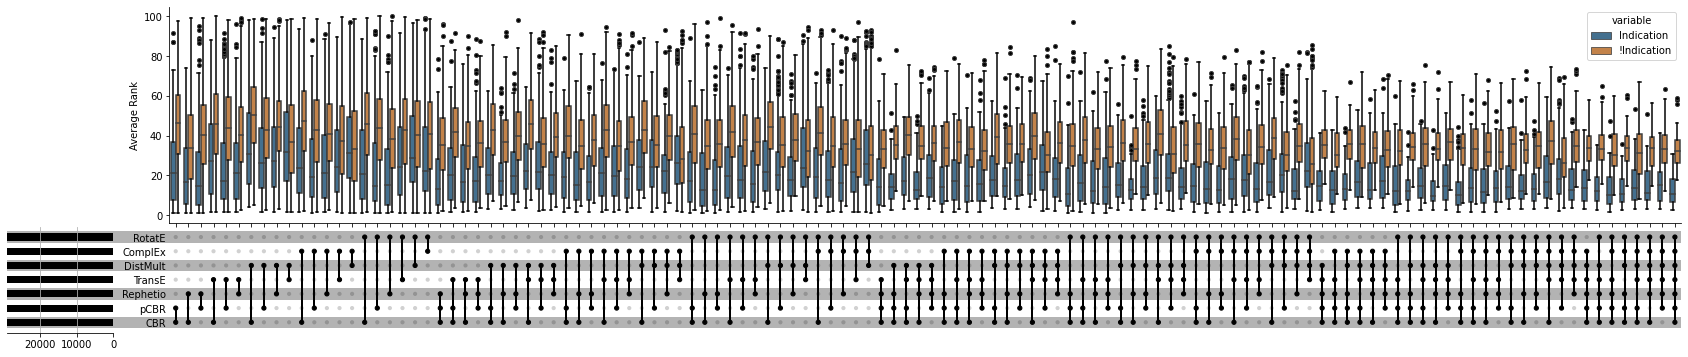

In [830]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 12

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.boxplot(
    data=mean_rank_df,
    x="ind",
    y="value",
    hue = "variable",
    #color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    #medianprops=dict(color="black"),
    #boxprops=dict(facecolor="none", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=4),
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Average Rank",
)
sns.despine(ax=ax0)

n = upsetplot2(
    data=(
        upset_df := upsetplot.from_memberships(
            memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
            data=overlap_df,
        )
        .reorder_levels(order=[0, 6, 3, 5, 2, 1, 4])
        .explode("result")
    ),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
n.plot_totals(ax1_totals)

### Plot reciprocal rank

In [831]:
# mean rank
rr_df = filtered_rank_df_combined[['algos','rr_ind_overlap','rr_not_ind_overlap']]
rr_df = filtered_rank_df_combined.rename(columns = {'rr_ind_overlap':'Indication','rr_not_ind_overlap':'!Indication'})
rr_df['Indication'] = rr_df.Indication.apply(lambda x: list(x.values()))
rr_df['!Indication']=rr_df['!Indication'].apply(lambda x: list(x.values()))
rr_df['ind'] = rr_df.algos.apply(lambda x: order_algo_dict[x])
rr_df = rr_df.melt(id_vars = ['algos','ind'],value_vars = ['Indication','!Indication']).explode('value')
rr_df

algos  ind     variable  \
0                                            (CBR, pCBR)    0   Indication   
1                                            (CBR, pCBR)    0   Indication   
2                                            (CBR, pCBR)    0   Indication   
3                                            (CBR, pCBR)    0   Indication   
4                                            (CBR, pCBR)    0   Indication   
...                                                  ...  ...          ...   
24957  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   
24958  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   
24959  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   
24960  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   
24961  (CBR, pCBR, Rephetio, TransE, DistMult, ComplE...  119  !Indication   

          value  
0      0.035407  
1           0.5  
2      0.035575  
3      0.333333  
4      0.084249  
...         ...  
24957  0.238988  
24958  0.082379  
24959  0.104628  
24960  0.083511  
24961  0.189382  

[127876 rows x 4 columns]

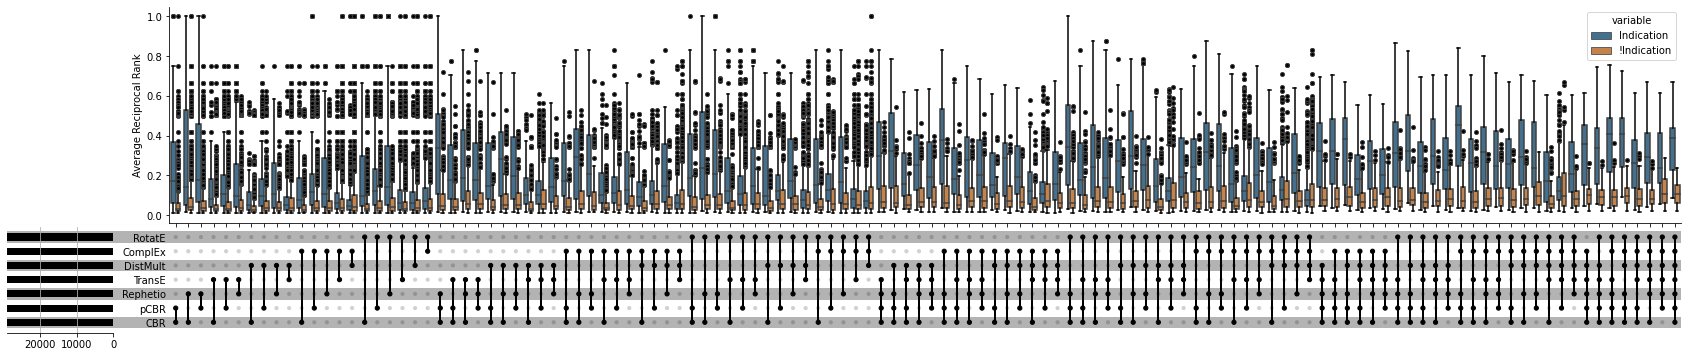

In [832]:
# fig starts here
fig = plt.figure(figsize=(30, 6), layout=None)

# spec size
spec_h, spec_w = 15, 124
spec = fig.add_gridspec(spec_h, spec_w)

bp_matrix_hratio = 2  # size of plot to matrix ratio 2:1
bp_h_max = int(bp_matrix_hratio * spec_h / (bp_matrix_hratio + 1))
bp_w_min = 12

# initialize subplots
ax0 = fig.add_subplot(spec[0:bp_h_max, bp_w_min:spec_w])
ax1_shading = fig.add_subplot(spec[bp_h_max:spec_h, 0:spec_w])
ax1_matrix = fig.add_subplot(
    spec[bp_h_max:spec_h, bp_w_min:spec_w], sharey=ax1_shading, sharex=ax0
)
ax1_totals = fig.add_subplot(spec[bp_h_max:spec_h, 0:8], sharey=ax1_matrix)


# box plot
sns.boxplot(
    data=rr_df,
    x="ind",
    y="value",
    hue = "variable",
    #color="white",
    saturation=0.5,
    width=0.75,
    ax=ax0,
    #medianprops=dict(color="black"),
    #boxprops=dict(facecolor="none", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(marker="o", markerfacecolor="black", markersize=4),
)
ax0.set(
    # xticks=[],
    xticklabels=[],
    xlabel="",
    ylabel="Average Reciprocal Rank",
)
sns.despine(ax=ax0)

n = upsetplot2(
    data=(
        upset_df := upsetplot.from_memberships(
            memberships=[list(k) for k, v in overlap_len_algo_combo_dict.items()],
            data=overlap_df,
        )
        .reorder_levels(order=[0, 6, 3, 5, 2, 1, 4])
        .explode("result")
    ),
    intersection_plot_elements=0,
    min_degree=2,
    shading_color=0.3,
    element_size=12,
)

n.plot_matrix(ax1_matrix)
n.plot_shading(ax1_shading)
n.plot_totals(ax1_totals)

## Generate re-ranked test results
* Hits@1,3,10
* MRR

In [834]:
rank_rerank_df.head()

NameError: name 'rank_rerank_df' is not defined

In [ ]:
# step 1: Get ranks
# step 2a: average the ranks of each entry and re-rank. (how to break ties?)
# step 2b: average the reciprocal ranks of each entry